# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**Описание данных**

* *airports_nearest* — расстояние до ближайшего аэропорта в метрах (м);
* *balcony* — число балконов;
* *ceiling_height* — высота потолков (м);
* *cityCenters_nearest* — расстояние до центра города (м);
* *days_exposition* — сколько дней было размещено объявление (от публикации до снятия);
* *first_day_exposition* — дата публикации;
* *floor* — этаж;
* *floors_total* — всего этажей в доме;
* *is_apartment* — апартаменты (булев тип);
* *kitchen_area* — площадь кухни в квадратных метрах (м²);
* *last_price* — цена на момент снятия с публикации;
* *living_area* — жилая площадь в квадратных метрах (м²);
* *locality_name* — название населённого пункта;
* *open_plan* — свободная планировка (булев тип);
* *parks_around3000* — число парков в радиусе 3 км;
* *parks_nearest* — расстояние до ближайшего парка (м);
* *ponds_around3000* — число водоёмов в радиусе 3 км;
* *ponds_nearest* — расстояние до ближайшего водоёма (м);
* *rooms* — число комнат;
* *studio* — квартира-студия (булев тип);
* *total_area* — площадь квартиры в квадратных метрах (м²);
* *total_images* — число фотографий квартиры в объявлении.

**План работ**

Этап 1. Обзор данных

Этап 2. Предобработка данных

* Определение и изучение пропущенных значений.
* Приведение данных к нужным типам.

Этап 3. Расчет и добавление новых данных в таблицу:

* цену квадратного метра;
* день недели, месяц и год публикации объявления;
* этаж квартиры; варианты — первый, последний, другой;
* соотношение жилой и общей площади, отношение площади кухни к общей.

Этап 4. Исследовательский анализ данных

* Изучение параметров: площадь, цена, число комнат, высота потолков.
* Изучение времени продажи квартиры.
* Выявление и удаление редких и выбивающихся значений.
* Выявление факторов больше всего влияющих на стоимость квартиры.
* Изучение 10 населённых пунктов с наибольшим числом объявлений.
* Изучение, как цена квартир зависит от удалённости от центра.
* Изучение сегмента квартир в центре.

Этап 5. Результаты

* Выводы
* Рекомендации

## Этап 1. Обзор данных

In [2]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pymystem3 import Mystem
from collections import Counter

In [3]:
# Прочитаем файл real_estate_data.csv из папки и сохраним его в переменной df
df = pd.read_csv(r"C:\Users\real_estate_data.csv", sep='\t')

In [5]:
# Выведем первые 10 строк датафрейма
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [6]:
# Выведем последние 10 строк датафрейма
df.tail(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23689,13,3550000.0,35.30,2018-02-28T00:00:00,1,2.86,15.0,16.3,4,NaN,...,9.10,2.0,Санкт-Петербург,17284.0,16081.0,1.0,353.0,2.0,652.0,29.0
23690,3,5500000.0,52.00,2018-07-19T00:00:00,2,NaN,5.0,31.0,2,NaN,...,6.00,NaN,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0
23691,11,9470000.0,72.90,2016-10-13T00:00:00,2,2.75,25.0,40.3,7,NaN,...,10.60,1.0,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.5,4,NaN,...,6.00,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23693,9,4600000.0,62.40,2016-08-05T00:00:00,3,2.60,9.0,40.0,8,NaN,...,8.00,0.0,Петергоф,45602.0,34104.0,1.0,352.0,1.0,675.0,239.0
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.50,5.0,12.3,1,NaN,...,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Выведем рандомные 10 строк датафрейма
df.sample(n=10, random_state = None)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
17856,9,1070000.0,30.7,2019-03-23T00:00:00,1,2.50,5.0,18.0,2,NaN,...,6.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983,7,3200000.0,34.0,2017-09-07T00:00:00,1,NaN,21.0,17.0,6,NaN,...,9.6,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,4.0
19471,14,4550000.0,75.0,2015-10-31T00:00:00,3,2.70,5.0,48.0,1,NaN,...,14.0,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,583.0
6807,0,3500000.0,30.6,2016-08-29T00:00:00,1,2.50,9.0,15.0,5,NaN,...,8.0,NaN,Санкт-Петербург,9869.0,11093.0,0.0,NaN,0.0,NaN,747.0
507,12,4200000.0,53.0,2017-09-11T00:00:00,2,NaN,9.0,27.7,4,NaN,...,10.4,2.0,посёлок Шушары,23450.0,29236.0,0.0,NaN,0.0,NaN,89.0
1364,8,3550000.0,51.0,2017-05-19T00:00:00,2,NaN,8.0,24.5,7,NaN,...,9.0,NaN,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,419.0
17593,11,7200000.0,90.0,2018-01-21T00:00:00,3,2.65,8.0,60.0,8,NaN,...,NaN,NaN,Санкт-Петербург,16231.0,15027.0,1.0,817.0,0.0,NaN,247.0
3385,13,4650000.0,49.0,2018-04-03T00:00:00,2,3.00,5.0,30.0,5,NaN,...,7.8,1.0,Санкт-Петербург,19264.0,13998.0,2.0,340.0,1.0,261.0,30.0
1681,14,6100000.0,45.0,2017-12-30T00:00:00,1,3.00,5.0,25.0,2,NaN,...,15.0,NaN,Санкт-Петербург,31284.0,4525.0,0.0,NaN,0.0,NaN,130.0
15539,18,19900000.0,100.0,2017-01-25T00:00:00,3,3.70,4.0,63.0,2,NaN,...,10.5,0.0,Санкт-Петербург,22704.0,1313.0,2.0,684.0,3.0,29.0,121.0


In [8]:
# Настроим отображение всех столбцов
pd.set_option('display.max_columns', None)

In [9]:
# Проверим отображение и снова выведем первые десять строк датафрейма
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [10]:
# Выведем основную информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [11]:
# Посмотрим описательные статистики датасета
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**Вывод**

Первичный осмотр датасета позволил выявить следующие проблемы:
* наличие пропусков;
* некорректные типы данных;
* аномальные значения.

Разберемся с этим более детально на следующих этапах работы.

## Этап 2. Предобработка данных

Далее:
* определим и изучим пропущенные значения;
* приведем данные к нужным типам.

### Определение и изучение пропущенных значений

In [12]:
# Посчитаем, сколько в таблице пропущенных значений
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [13]:
# Посмотрим долю запоняемости данных по каждому из признаков
df.isna().sum().sort_values() / len(df) * 100

total_images             0.000000
open_plan                0.000000
floor                    0.000000
rooms                    0.000000
studio                   0.000000
total_area               0.000000
last_price               0.000000
first_day_exposition     0.000000
locality_name            0.206760
floors_total             0.362885
living_area              8.029875
kitchen_area             9.612220
days_exposition         13.422507
ponds_around3000        23.283683
parks_around3000        23.283683
cityCenters_nearest     23.287902
airports_nearest        23.384953
ceiling_height          38.799105
balcony                 48.605426
ponds_nearest           61.559559
parks_nearest           65.909954
is_apartment            88.290645
dtype: float64

Интерпретация пропущенных данных:

1. В большинстве пропущенных строк отсутствуют расстояния до центра города и аэропортов; прудов, парков и их колличество в радиусе 3000 метров. Вероятно, при указании геолокации сервис должен заполнять эти значения автоматически. Но, возможно, по техническим причинам этого было не сделано.
2. У 39% строк отсутствует высота потолка. При указании геолокации сервис также мог бы заполнять пропущенные данные в автоматическом режиме исходя из типа постройки.
3. В 13% случаев не указано, сколько дней было размещено объявление (от публикации до его снятия). Возможно, оно так и осталось висеть на сервисе.
4. Пропущенные значения есть в столбцах с жилой площадью, площадью кухни и количеством балконов. Скорее всего, эти данные просто не были указаны при заполнении вручную.
5. В 88% объявлений не указано имеет ли недвижимость статус апартаментов. Скорее всего, поле игнорировалось при отсутствии этого статуса.

In [14]:
# Поменяем последовательность столбцов на более последовательную по важности информации
df = df[[
 'locality_name', 
 'living_area',
 'kitchen_area',
 'total_area',
 'rooms',
 'ceiling_height',
 'last_price',
 'balcony',
 'floor',
 'floors_total',
 'is_apartment',
 'studio',
 'open_plan',
 'first_day_exposition',
 'days_exposition',  
 'cityCenters_nearest',
 'airports_nearest',
 'parks_around3000',
 'parks_nearest', 
 'ponds_around3000',
 'ponds_nearest',
 'total_images',
]]

In [15]:
# Посмотрим, как получилось
df.head()

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
0,Санкт-Петербург,51.0,25.0,108.0,3,2.70,13000000.0,NaN,8,16.0,NaN,False,False,2019-03-07T00:00:00,NaN,16028.0,18863.0,1.0,482.0,2.0,755.0,20
1,посёлок Шушары,18.6,11.0,40.4,1,NaN,3350000.0,2.0,1,11.0,NaN,False,False,2018-12-04T00:00:00,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN,7
2,Санкт-Петербург,34.3,8.3,56.0,2,NaN,5196000.0,0.0,4,5.0,NaN,False,False,2015-08-20T00:00:00,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0,10
3,Санкт-Петербург,NaN,NaN,159.0,3,NaN,64900000.0,0.0,9,14.0,NaN,False,False,2015-07-24T00:00:00,424.0,6800.0,28098.0,2.0,84.0,3.0,234.0,0
4,Санкт-Петербург,32.0,41.0,100.0,2,3.03,10000000.0,NaN,13,14.0,NaN,False,False,2018-06-19T00:00:00,121.0,8098.0,31856.0,2.0,112.0,1.0,48.0,2


In [16]:
# Заменим пропуски в 'balcony' на 0, согласно вводным условиям и изменим тип данных на int
df['balcony'] = df['balcony'].fillna(0).astype(int)

In [17]:
# Дату публикации приведем в формат год-месяц-день, убрав лишнюю информацию
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')

In [18]:
# Выведем первые 10 строк датафрейма
df.head(10)

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
0,Санкт-Петербург,51.00,25.00,108.00,3,2.70,13000000.0,0,8,16.0,NaN,False,False,2019-03-07,NaN,16028.0,18863.0,1.0,482.0,2.0,755.0,20
1,посёлок Шушары,18.60,11.00,40.40,1,NaN,3350000.0,2,1,11.0,NaN,False,False,2018-12-04,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN,7
2,Санкт-Петербург,34.30,8.30,56.00,2,NaN,5196000.0,0,4,5.0,NaN,False,False,2015-08-20,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0,10
3,Санкт-Петербург,NaN,NaN,159.00,3,NaN,64900000.0,0,9,14.0,NaN,False,False,2015-07-24,424.0,6800.0,28098.0,2.0,84.0,3.0,234.0,0
4,Санкт-Петербург,32.00,41.00,100.00,2,3.03,10000000.0,0,13,14.0,NaN,False,False,2018-06-19,121.0,8098.0,31856.0,2.0,112.0,1.0,48.0,2
5,городской посёлок Янино-1,14.40,9.10,30.40,1,NaN,2890000.0,0,5,12.0,NaN,False,False,2018-09-10,55.0,NaN,NaN,NaN,NaN,NaN,NaN,10
6,посёлок Парголово,10.60,14.40,37.30,1,NaN,3700000.0,1,6,26.0,NaN,False,False,2017-11-02,155.0,19143.0,52996.0,0.0,NaN,0.0,NaN,6
7,Санкт-Петербург,NaN,18.90,71.60,2,NaN,7915000.0,2,22,24.0,NaN,False,False,2019-04-18,NaN,11634.0,23982.0,0.0,NaN,0.0,NaN,5
8,посёлок Мурино,15.43,8.81,33.16,1,NaN,2900000.0,0,26,27.0,NaN,False,False,2018-05-23,189.0,NaN,NaN,NaN,NaN,NaN,NaN,20
9,Санкт-Петербург,43.60,6.50,61.00,3,2.50,5400000.0,2,7,9.0,NaN,False,False,2017-02-26,289.0,15008.0,50898.0,0.0,NaN,0.0,NaN,18


In [19]:
# Cтолбец апартаменты, видимо, появился не вместе с началом ведения записей, все пропущенные значения заменим на False, 
# Апартаменты появились относительно недавно
df['is_apartment'] = df['is_apartment'].fillna(False)

In [20]:
# Изменим тип данных в столбцах, где не нужна точность после запятой
astype_cols = [col for col in df.columns if col in ['cityCenters_nearest', 'airports_nearest', 'parks_around3000', 'ponds_nearest']]
for col in astype_cols:
    df[col] = df[col].astype('Int64')

In [22]:
# Выведем основную информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   locality_name         23650 non-null  object        
 1   living_area           21796 non-null  float64       
 2   kitchen_area          21421 non-null  float64       
 3   total_area            23699 non-null  float64       
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   last_price            23699 non-null  float64       
 7   balcony               23699 non-null  int32         
 8   floor                 23699 non-null  int64         
 9   floors_total          23613 non-null  float64       
 10  is_apartment          23699 non-null  bool          
 11  studio                23699 non-null  bool          
 12  open_plan             23699 non-null  bool          
 13  first_day_exposi

In [23]:
# Посчитаем количество пропусков в колонке с площадью кухни
df['kitchen_area'].isna().sum()

2278

In [24]:
# Зная 'total_area' и 'living_area', узнаем их разность и заполним 'kitchen_area'
df.loc[(df['living_area'] > 0) & (df['kitchen_area'].isna() == True), 'kitchen_area'] = df['total_area'] - df['living_area']

In [25]:
# Посмотрим cколько пропусков 'kitchen_area' осталось после замены
df['kitchen_area'].isna().sum()

1464

In [26]:
# Посчитаем долю того, что удалось заполнить
round(100 - (1464 / 2278 * 100))

36

In [27]:
# Посчитаем количество пропусков в колонке с жилой площадью
df['living_area'].isna().sum()

1903

In [28]:
# Зная 'total_area' и 'kitchen_area', узнаем их разность и заполним 'living_area' 
df.loc[(df['kitchen_area'] > 0) & (df['living_area'].isna() == True), 'living_area'] = df['total_area'] - df['kitchen_area']

In [29]:
# Посмотрим cколько пропусков 'living_area' осталось после замены
df['living_area'].isna().sum()

1464

Высота потолков. Данная графа не заполнена у 39% объектов недвижимости, при этом у заполненных цифр есть довольно нереальные значения.

In [30]:
# Посмотрим на уникальные значения в колонке с высотой потолков 'ceiling_height'
df['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

В соответсвии с законодательством РФ, высота потолков у жилой недвижимости не может быть менее 2,5 м.

Объявления с потолками выше пяти метров скорее всего являются коммерческими объектами. А те, что с потолками выше 20 метров — человеческой ошибкой при заполнении.

In [31]:
# Выберем объявления с высотой потолков менее 2,5 м
df[df['ceiling_height'] < 2.5]

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
193,Санкт-Петербург,55.9,9.8,83.8,4,2.47,7920000.0,1,9,9.0,False,False,False,2017-08-17,155.0,7724,30352,0,NaN,1.0,289,6
227,посёлок Новый Свет,NaN,NaN,47.0,3,2.34,2200000.0,0,1,5.0,False,False,False,2018-01-12,45.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,13
552,Санкт-Петербург,17.5,6.5,33.5,1,2.00,2999000.0,0,6,15.0,False,False,False,2017-03-30,270.0,11746,33972,1,520.0,1.0,949,11
632,посёлок городского типа Кузьмоловский,21.0,6.0,35.0,2,2.45,3350000.0,2,9,9.0,False,False,False,2017-11-14,NaN,<NA>,<NA>,<NA>,NaN,NaN,<NA>,20
987,Санкт-Петербург,51.0,9.4,65.5,4,2.46,7100000.0,0,4,5.0,False,False,False,2016-03-30,82.0,5110,24542,1,572.0,0.0,<NA>,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22590,Санкт-Петербург,32.4,10.0,55.0,2,1.00,6000000.0,0,7,12.0,False,False,False,2018-10-31,13.0,14217,33053,2,293.0,2.0,289,16
22960,Всеволожск,19.0,10.0,53.6,2,2.00,2300000.0,0,1,2.0,False,False,False,2018-10-18,NaN,<NA>,<NA>,<NA>,NaN,NaN,<NA>,17
23121,Санкт-Петербург,20.0,7.8,35.2,1,2.47,4290000.0,1,7,14.0,False,False,False,2018-09-12,41.0,13142,7900,1,506.0,0.0,<NA>,20
23496,Сертолово,31.0,8.4,55.3,2,2.45,3300000.0,3,2,14.0,False,False,False,2018-06-19,62.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,7


In [32]:
# Выберем объявления с высотой потолков более 5 м
df[df['ceiling_height'] > 5]

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
355,Гатчина,32.0,23.2,55.2,2,25.0,3600000.0,2,2,5.0,False,False,False,2018-07-12,259.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,17
464,Санкт-Петербург,159.5,21.1,280.3,6,5.2,66571000.0,0,7,8.0,False,False,False,2015-06-11,578.0,6655,26316,3,187.0,1.0,616,15
1026,Санкт-Петербург,190.0,63.0,310.0,5,5.3,155000000.0,2,3,3.0,False,False,False,2018-10-12,NaN,4785,24899,0,NaN,1.0,603,20
1388,Санкт-Петербург,NaN,NaN,399.0,5,5.6,59800000.0,0,6,6.0,False,False,False,2015-01-21,719.0,6934,26204,2,149.0,2.0,577,20
3148,Волхов,53.0,8.0,75.0,3,32.0,2900000.0,0,2,3.0,False,False,False,2018-11-12,NaN,<NA>,<NA>,<NA>,NaN,NaN,<NA>,14
3474,деревня Нурма,15.3,7.3,30.0,1,8.0,1400000.0,0,2,5.0,False,False,False,2018-03-16,125.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,3
4643,Санкт-Петербург,30.0,7.0,45.0,2,25.0,4300000.0,1,2,9.0,False,False,False,2018-02-01,181.0,13256,12016,1,658.0,1.0,331,0
4876,посёлок Мурино,17.0,8.0,25.0,0,27.0,3000000.0,2,17,25.0,False,False,True,2017-09-27,28.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,7
5076,Санкт-Петербург,19.5,5.5,30.5,1,24.0,3850000.0,0,1,5.0,True,False,False,2018-10-03,7.0,8389,29686,3,397.0,1.0,578,0
5246,деревня Мины,30.0,9.0,54.0,2,27.0,2500000.0,2,3,5.0,False,False,False,2017-10-13,540.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,0


In [33]:
# Разделим высоту потолков выше 20 м на 10
df.loc[(df['ceiling_height'] >= 20), 'ceiling_height'] = df['ceiling_height'] / 10

In [34]:
# Проверим получившиеся данные
df[df['ceiling_height'] > 5]

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
464,Санкт-Петербург,159.5,21.1,280.3,6,5.2,66571000.0,0,7,8.0,False,False,False,2015-06-11,578.0,6655,26316,3,187.0,1.0,616,15
1026,Санкт-Петербург,190.0,63.0,310.0,5,5.3,155000000.0,2,3,3.0,False,False,False,2018-10-12,NaN,4785,24899,0,NaN,1.0,603,20
1388,Санкт-Петербург,NaN,NaN,399.0,5,5.6,59800000.0,0,6,6.0,False,False,False,2015-01-21,719.0,6934,26204,2,149.0,2.0,577,20
3474,деревня Нурма,15.3,7.3,30.0,1,8.0,1400000.0,0,2,5.0,False,False,False,2018-03-16,125.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,3
5863,Санкт-Петербург,19.3,8.3,45.0,1,8.3,5650000.0,1,14,16.0,False,False,False,2018-08-15,14.0,10763,13069,0,NaN,1.0,613,20
7578,Санкт-Петербург,83.0,29.0,143.0,3,5.5,38000000.0,1,5,5.0,False,False,False,2017-11-02,NaN,6448,26333,3,479.0,0.0,<NA>,17
12628,Санкт-Петербург,NaN,NaN,50.0,1,5.3,3900000.0,0,5,5.0,False,False,False,2018-03-29,8.0,3918,19644,1,505.0,1.0,92,14
15061,Санкт-Петербург,32.4,9.1,56.4,2,14.0,5600000.0,2,5,14.0,False,False,False,2018-05-11,315.0,13610,14814,0,NaN,0.0,<NA>,19
15743,Санкт-Петербург,41.0,8.0,67.0,3,8.0,5600000.0,0,1,16.0,False,False,False,2016-11-11,474.0,11035,32691,1,723.0,0.0,<NA>,14
17442,Красное Село,29.0,25.0,54.0,2,8.0,5350000.0,1,2,5.0,False,False,False,2015-06-16,469.0,28062,24638,0,NaN,0.0,<NA>,0


Теперь заполним пропущенные значения высоты потолков. Если бы мы знали типовой проект дома, то можно было бы посмотреть высоту в аналогичных квартирах в данных проектах. Так как такими данными мы не располагаем, пропуски придется заполнять медианными значениями.

In [35]:
# Определим строки с пропущенными значениями в колонке с высотой потолков 'ceiling_height'
df[df['ceiling_height'].isna()]

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images
1,посёлок Шушары,18.6,11.0,40.4,1,NaN,3350000.0,2,1,11.0,False,False,False,2018-12-04,81.0,18603,12817,0,NaN,0.0,<NA>,7
2,Санкт-Петербург,34.3,8.3,56.0,2,NaN,5196000.0,0,4,5.0,False,False,False,2015-08-20,558.0,13933,21741,1,90.0,2.0,574,10
3,Санкт-Петербург,NaN,NaN,159.0,3,NaN,64900000.0,0,9,14.0,False,False,False,2015-07-24,424.0,6800,28098,2,84.0,3.0,234,0
5,городской посёлок Янино-1,14.4,9.1,30.4,1,NaN,2890000.0,0,5,12.0,False,False,False,2018-09-10,55.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,10
6,посёлок Парголово,10.6,14.4,37.3,1,NaN,3700000.0,1,6,26.0,False,False,False,2017-11-02,155.0,19143,52996,0,NaN,0.0,<NA>,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23687,Санкт-Петербург,20.0,11.0,39.0,1,NaN,3200000.0,2,6,9.0,False,False,False,2017-12-16,38.0,16704,40837,0,NaN,0.0,<NA>,6
23690,Санкт-Петербург,31.0,6.0,52.0,2,NaN,5500000.0,0,2,5.0,False,False,False,2018-07-19,15.0,6263,20151,1,300.0,0.0,<NA>,3
23692,Тихвин,17.5,6.0,30.0,1,NaN,1350000.0,0,4,5.0,False,False,False,2017-07-07,413.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,2
23695,Тосно,38.0,8.5,59.0,3,NaN,3100000.0,0,4,5.0,False,False,False,2018-01-15,45.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,14


In [36]:
# Посчитаем медианные значения высоты потолков для каждой из этажности 
ceiling_medians = df.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count'])
ceiling_medians.columns = ['median', 'count']
ceiling_medians.head()

,median,count
floors_total,,
1.0,2.80,10
2.0,2.70,215
3.0,2.80,399
4.0,3.00,789
5.0,2.55,3666


In [37]:
# Медианные значения записываем на места пропущенных значений высоты потолков домов соответствующей этажности
for floor in ceiling_medians.index:
    df.loc[(df['ceiling_height'].isna()) & (df['floors_total'] == floor), 'ceiling_height'] = ceiling_medians.loc[floor, 'median']

In [39]:
# В домах где этажность неизвестна, заменяем значения высоты потолков на общую медиану
for floor in ceiling_medians.index:
    df.loc[(df['floors_total'].isna()) | ((df['floors_total'] == floor) & (ceiling_medians.loc[floor, 'count'] == 0)), 'ceiling_height'] = df['ceiling_height'].median()

In [40]:
df['ceiling_height'].isna().sum()

0

In [41]:
df.query("ceiling_height.isna() == 'True'")

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images


In [42]:
# Посмотрим количество строк без указания населенного пункта
df['locality_name'].isna().sum()

49

In [43]:
# Удалим их, так они могут исказить наше иследование
df.dropna(subset=['locality_name'], inplace=True)

In [44]:
# Посмотрим корректность удаления строк без указания населенного пункта 
df['locality_name'].isna().sum()

0

## Этап 3. Расчет и добавление новых данных в таблицу

Далее рассчитаем:
* цену квадратного метра;
* день недели, месяц и год публикации объявления;
* этаж квартиры; варианты — первый, последний, другой;
* соотношение жилой и общей площади, отношение площади кухни к общей.

### Цена квадратного метра

In [45]:
# Расччитаем цену квадратного метра, округлим и изменим тип данных на int
df['price_for_meter'] = round(df['last_price'] / df['total_area']).astype('int64')

### День неделя, месяц и год публикации объявления

In [46]:
# Запишем данные дня недели, месяца и года в каждый столбец по отдельности
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year

In [47]:
df.head(10)

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year
0,Санкт-Петербург,51.00,25.00,108.00,3,2.70,13000000.0,0,8,16.0,False,False,False,2019-03-07,NaN,16028,18863,1,482.0,2.0,755,20,120370,3,3,2019
1,посёлок Шушары,18.60,11.00,40.40,1,2.75,3350000.0,2,1,11.0,False,False,False,2018-12-04,81.0,18603,12817,0,NaN,0.0,<NA>,7,82921,1,12,2018
2,Санкт-Петербург,34.30,8.30,56.00,2,2.55,5196000.0,0,4,5.0,False,False,False,2015-08-20,558.0,13933,21741,1,90.0,2.0,574,10,92786,3,8,2015
3,Санкт-Петербург,NaN,NaN,159.00,3,2.60,64900000.0,0,9,14.0,False,False,False,2015-07-24,424.0,6800,28098,2,84.0,3.0,234,0,408176,4,7,2015
4,Санкт-Петербург,32.00,41.00,100.00,2,3.03,10000000.0,0,13,14.0,False,False,False,2018-06-19,121.0,8098,31856,2,112.0,1.0,48,2,100000,1,6,2018
5,городской посёлок Янино-1,14.40,9.10,30.40,1,2.65,2890000.0,0,5,12.0,False,False,False,2018-09-10,55.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,10,95066,0,9,2018
6,посёлок Парголово,10.60,14.40,37.30,1,2.66,3700000.0,1,6,26.0,False,False,False,2017-11-02,155.0,19143,52996,0,NaN,0.0,<NA>,6,99196,3,11,2017
7,Санкт-Петербург,52.70,18.90,71.60,2,2.75,7915000.0,2,22,24.0,False,False,False,2019-04-18,NaN,11634,23982,0,NaN,0.0,<NA>,5,110545,3,4,2019
8,посёлок Мурино,15.43,8.81,33.16,1,2.70,2900000.0,0,26,27.0,False,False,False,2018-05-23,189.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,20,87455,2,5,2018
9,Санкт-Петербург,43.60,6.50,61.00,3,2.50,5400000.0,2,7,9.0,False,False,False,2017-02-26,289.0,15008,50898,0,NaN,0.0,<NA>,18,88525,6,2,2017


### Этажность квартиры

In [48]:
# Создадим функцию этажности квартиры и применим ее
# Варианты — первый, последний, другой
def floor_category(df):
    if df['floor'] == 1:
        return 'первый'
    elif ((df['floor'] == df['floors_total']) & (df['floor'] != 1)):
        return 'последний'
    else:
        return 'другой'

In [49]:
df['floor_category'] = df.apply(floor_category, axis=1)

In [50]:
df.head()

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category
0,Санкт-Петербург,51.0,25.0,108.0,3,2.70,13000000.0,0,8,16.0,False,False,False,2019-03-07,NaN,16028,18863,1,482.0,2.0,755,20,120370,3,3,2019,другой
1,посёлок Шушары,18.6,11.0,40.4,1,2.75,3350000.0,2,1,11.0,False,False,False,2018-12-04,81.0,18603,12817,0,NaN,0.0,<NA>,7,82921,1,12,2018,первый
2,Санкт-Петербург,34.3,8.3,56.0,2,2.55,5196000.0,0,4,5.0,False,False,False,2015-08-20,558.0,13933,21741,1,90.0,2.0,574,10,92786,3,8,2015,другой
3,Санкт-Петербург,NaN,NaN,159.0,3,2.60,64900000.0,0,9,14.0,False,False,False,2015-07-24,424.0,6800,28098,2,84.0,3.0,234,0,408176,4,7,2015,другой
4,Санкт-Петербург,32.0,41.0,100.0,2,3.03,10000000.0,0,13,14.0,False,False,False,2018-06-19,121.0,8098,31856,2,112.0,1.0,48,2,100000,1,6,2018,другой


### Соотношение жилой и общей площади, отношение площади кухни к общей

In [51]:
# Определим соотношение жилой и общей площади, отношение площади кухни к общей
df['living_area_ratio'] = round(df['living_area'] / df['total_area'], 2)
df['kitchen_area_ratio'] = round(df['kitchen_area'] / df['total_area'], 2)

In [48]:
df.head()

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio
0,Санкт-Петербург,51.0,25.0,108.0,3,2.70,13000000.0,0,8,16.0,False,False,False,2019-03-07,NaN,16028,18863,1,482.0,2.0,755,20,120370,3,3,2019,другой,0.47,0.23
1,посёлок Шушары,18.6,11.0,40.4,1,2.75,3350000.0,2,1,11.0,False,False,False,2018-12-04,81.0,18603,12817,0,NaN,0.0,<NA>,7,82921,1,12,2018,первый,0.46,0.27
2,Санкт-Петербург,34.3,8.3,56.0,2,2.55,5196000.0,0,4,5.0,False,False,False,2015-08-20,558.0,13933,21741,1,90.0,2.0,574,10,92786,3,8,2015,другой,0.61,0.15
3,Санкт-Петербург,NaN,NaN,159.0,3,2.60,64900000.0,0,9,14.0,False,False,False,2015-07-24,424.0,6800,28098,2,84.0,3.0,234,0,408176,4,7,2015,другой,NaN,NaN
4,Санкт-Петербург,32.0,41.0,100.0,2,3.03,10000000.0,0,13,14.0,False,False,False,2018-06-19,121.0,8098,31856,2,112.0,1.0,48,2,100000,1,6,2018,другой,0.32,0.41


## Этап 4. Исследовательский анализ данных

* Изучение параметров: площадь, цена, число комнат, высота потолков.
* Изучение времени продажи квартиры.
* Выявление и удаление редких и выбивающихся значений.
* Выявление факторов больше всего влияющих на стоимость квартиры.
* Изучение 10 населённых пунктов с наибольшим числом объявлений.
* Изучение, как цена квартир зависит от удалённости от центра.
* Изучение сегмента квартир в центре.

### Изучение параметров: площадь, цена, число комнат, высота потолков

Постройте гистограммы для каждого параметра.

In [49]:
# Посмотрим стандартное отклонение набора интересующих нас данных
df[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,23650.000000,2.365000e+04,23650.000000,23650.000000
mean,60.329069,6.541127e+06,2.070106,2.709225
std,35.661808,1.089640e+07,1.078620,0.265112
min,12.000000,1.219000e+04,0.000000,1.000000
25%,40.000000,3.400000e+06,1.000000,2.550000
50%,52.000000,4.650000e+06,2.000000,2.650000
75%,69.700000,6.799000e+06,3.000000,2.750000
max,900.000000,7.630000e+08,19.000000,14.000000


Интерпретация описательных данных:
1. В соотсветствии с медианными данными самой популярной жилой площадью является двухкомнатная квартира с общей площадью 52 кв. м и высотой потолков 2,65 м, стоимость которой составляет 4,65 млн. рублей.
2. Самой дорогой является 19-комнатная квартира стоимость 7,63 млн. рублей с общей площадью 900 кв. м. и высотой потолков 14 м.
3. Самым недорогим жильем является квартира-студия площадью 12 кв. м ценою 1,2 млн. рублей.

#### Площадь

In [52]:
# Посмотрим, как распределяются данные о площади квартир
df['total_area'].describe()

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

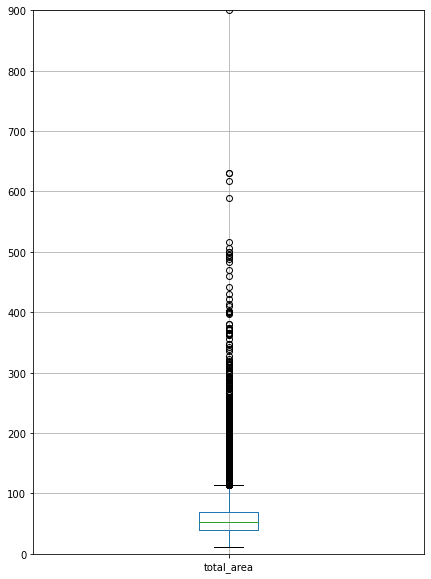

In [53]:
df.boxplot(column='total_area', figsize=(7, 10))
plt.ylim(0,900)
plt.show()

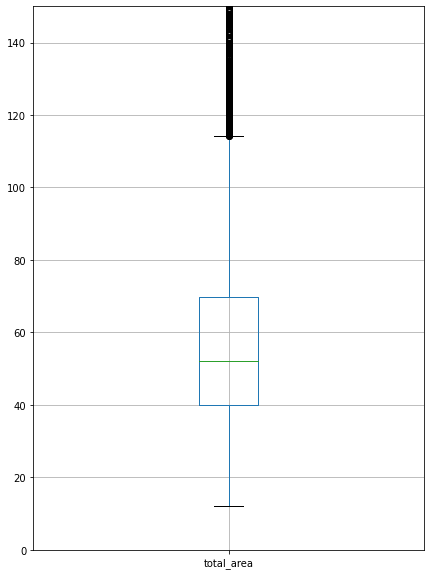

In [54]:
# Очень длинный ус выбросов с увеличенной площадью квартир, приблизим пределы нормальных значений
df.boxplot(column='total_area', figsize=(7, 10))
plt.ylim(0,150)
plt.show()

In [55]:
# Выяснили, что средними и медианным значением является площадь 52 кв. м, но есть квартиры в разы больше и даже 900 кв. м
# Посмотрим Топ 10 самых больших квартир
df.sort_values(by='total_area', ascending=False).head(10)

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio
19540,Санкт-Петербург,409.7,112.0,900.0,12,2.80,420000000.0,0,25,25.0,False,False,False,2017-12-06,106.0,7877,30706,0,NaN,2.0,318,8,466667,2,12,2017,последний,0.46,0.12
12859,Санкт-Петербург,322.3,19.5,631.2,7,3.90,140000000.0,1,4,4.0,False,False,False,2019-04-09,NaN,4972,25707,0,NaN,2.0,210,20,221800,1,4,2019,последний,0.51,0.03
3117,Санкт-Петербург,571.0,60.0,631.0,7,2.55,140000000.0,0,5,5.0,False,False,False,2019-03-30,NaN,4972,25707,0,NaN,2.0,210,19,221870,5,3,2019,последний,0.90,0.10
15651,Санкт-Петербург,258.0,70.0,618.0,7,3.40,300000000.0,0,5,7.0,False,False,False,2017-12-18,111.0,5297,32440,0,NaN,2.0,198,20,485437,0,12,2017,другой,0.42,0.11
5358,Санкт-Петербург,409.0,100.0,590.0,15,3.50,65000000.0,0,3,6.0,False,False,False,2019-02-14,14.0,4666,24447,1,767.0,0.0,<NA>,20,110169,3,2,2019,другой,0.69,0.17
4237,Санкт-Петербург,332.0,22.0,517.0,7,3.00,50000000.0,0,3,4.0,False,False,False,2017-10-14,NaN,1847,22835,2,477.0,2.0,540,1,96712,5,10,2017,другой,0.64,0.04
8018,Санкт-Петербург,301.5,45.5,507.0,5,4.45,84000000.0,1,7,7.0,True,False,False,2015-12-17,1078.0,5735,<NA>,2,110.0,0.0,<NA>,20,165680,3,12,2015,последний,0.59,0.09
15016,Санкт-Петербург,NaN,NaN,500.0,4,3.20,150000000.0,0,7,7.0,False,False,False,2016-01-13,303.0,6150,33058,3,209.0,3.0,531,8,300000,2,1,2016,последний,NaN,NaN
5893,Санкт-Петербург,460.0,40.0,500.0,6,3.00,230000000.0,0,7,7.0,False,False,False,2017-05-31,50.0,5297,32440,0,NaN,2.0,198,3,460000,2,5,2017,последний,0.92,0.08
12401,Санкт-Петербург,347.5,25.0,495.0,7,4.65,91500000.0,0,7,7.0,False,False,False,2017-06-19,14.0,5735,<NA>,2,110.0,0.0,<NA>,20,184848,0,6,2017,последний,0.70,0.05


Эх, кто не мечтает иметь 500-600 кв. м в Питере?
Но есть явно выделяющийся объект недвижимости в 900 кв. м. Его мы оставим как артефакт. Значения меньше 20 кв. м, это, вероятно студии, посмотрим детально.

In [56]:
# Посмотрим квартиры с значениями общей площади меньше 20 кв. м
# df[(df['total_area'] <= 20) & (df['total_area'] != 'NaN')].sort_values(by='total_area', ascending=False)
df.query("total_area <= 20").sort_values(by='total_area', ascending=False)

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio
21419,Санкт-Петербург,14.00,2.00,20.00,1,2.50,1870000.0,0,1,5.0,False,False,False,2018-03-06,45.0,15654,16652,1,619.0,1.0,937,4,93500,1,3,2018,первый,0.70,0.10
5312,деревня Кудрово,16.00,4.00,20.00,0,2.75,1800000.0,0,10,19.0,False,True,False,2018-02-01,53.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,3,90000,3,2,2018,другой,0.80,0.20
19477,Санкт-Петербург,16.00,4.00,20.00,0,2.60,2300000.0,0,1,10.0,False,False,True,2017-11-10,35.0,12652,29791,0,NaN,1.0,815,11,115000,4,11,2017,первый,0.80,0.20
17860,Санкт-Петербург,NaN,NaN,20.00,1,3.00,2385000.0,0,2,6.0,False,False,False,2018-12-11,25.0,2903,23361,0,NaN,1.0,1002,1,119250,1,12,2018,другой,NaN,NaN
8873,Санкт-Петербург,14.00,6.00,20.00,1,3.00,2950000.0,0,1,7.0,False,False,False,2016-06-18,38.0,4621,24053,1,247.0,0.0,<NA>,6,147500,5,6,2016,первый,0.70,0.30
16991,посёлок Мурино,NaN,NaN,20.00,1,2.75,1750000.0,2,18,22.0,False,False,False,2015-08-12,757.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,2,87500,2,8,2015,другой,NaN,NaN
4077,Санкт-Петербург,13.00,5.60,20.00,2,3.00,3000000.0,0,2,6.0,False,False,False,2017-04-10,16.0,6996,28450,2,223.0,1.0,611,10,150000,0,4,2017,другой,0.65,0.28
10964,Всеволожск,16.00,4.00,20.00,1,2.80,1150000.0,0,1,3.0,False,False,False,2017-03-04,108.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,3,57500,5,3,2017,первый,0.80,0.20
5855,поселок городского типа Дубровка,12.70,6.80,19.50,0,2.76,945750.0,0,2,3.0,False,True,False,2017-09-18,3.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,3,48500,0,9,2017,другой,0.65,0.35
9817,Санкт-Петербург,15.00,4.00,19.00,0,3.50,2190000.0,0,1,5.0,False,True,False,2018-10-12,89.0,8264,29561,2,383.0,1.0,781,8,115263,4,10,2018,первый,0.79,0.21


Можно было бы подумать, что квартира 12 кв. м это ошибка, но судя по остальным данным о ней, это реальность и находится она в самом центре СПб, цена тоже косвенно на это намекает. Ок, оставляем к исследованию.

<AxesSubplot:>

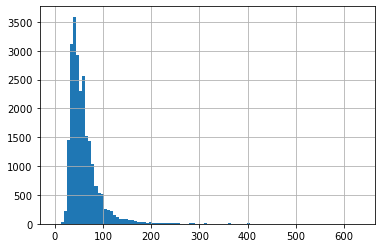

In [57]:
# Построим гистограмму площади, без артефакта 900 кв. м
df['total_area'].hist(bins=100, range=(0,632))

Пределы нормальных значений площади квартир 40-70 кв. м, нормальными можно считать и квартиры площадью от 12 до 120 кв. м, квартиры же большей площади уже являются аномально большими.

#### Цена

In [58]:
df['last_price'].describe()

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

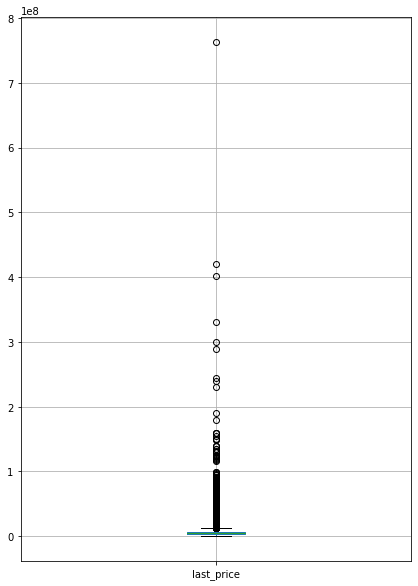

In [59]:
df.boxplot(column='last_price', figsize=(7, 10))
plt.show()

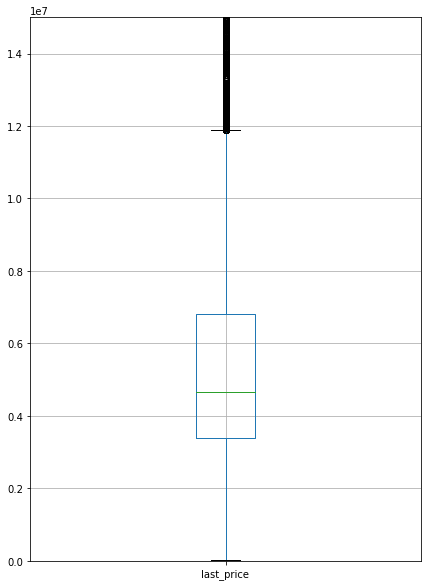

In [60]:
# Приблизим пределы нормальных значений
df.boxplot(column='last_price', figsize = (7,10))
plt.ylim(0,15000000)
plt.show()

In [61]:
# Посмотрим минимальные цены квартир
df.sort_values(by='last_price', ascending=True).head(10)

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio
8793,Санкт-Петербург,32.0,40.5,109.0,2,2.75,12190.0,0,25,25.0,False,False,False,2019-03-20,8.0,9176,36421,1,805.0,0.0,<NA>,7,112,2,3,2019,последний,0.29,0.37
17456,Сланцы,16.0,6.0,30.4,1,2.70,430000.0,0,1,2.0,False,False,False,2019-04-22,NaN,<NA>,<NA>,<NA>,NaN,NaN,<NA>,7,14145,0,4,2019,первый,0.53,0.20
14911,посёлок станции Свирь,NaN,NaN,54.0,2,2.80,430000.0,0,3,3.0,False,False,False,2018-06-26,44.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,5,7963,1,6,2018,последний,NaN,NaN
16274,деревня Старополье,NaN,NaN,40.0,1,2.55,440000.0,0,1,5.0,False,False,False,2018-07-10,45.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,18,11000,1,7,2018,первый,NaN,NaN
17676,деревня Ям-Тесово,17.3,8.5,36.5,1,2.55,450000.0,1,4,5.0,False,False,False,2018-02-01,120.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,0,12329,3,2,2018,другой,0.47,0.23
9581,деревня Старополье,30.3,5.5,43.4,2,2.55,450000.0,0,3,5.0,False,False,False,2018-08-31,96.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,7,10369,4,8,2018,другой,0.70,0.13
5698,городской посёлок Будогощь,23.0,5.8,42.0,2,2.80,450000.0,0,1,1.0,False,False,False,2017-07-31,233.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,7,10714,0,7,2017,первый,0.55,0.14
16219,деревня Вахнова Кара,NaN,NaN,38.5,2,2.65,450000.0,0,1,2.0,False,False,False,2018-07-11,45.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,14,11688,2,7,2018,первый,NaN,NaN
23484,Сланцы,28.0,7.5,44.5,2,2.70,470000.0,0,2,2.0,False,False,False,2018-07-02,298.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,11,10562,0,7,2018,последний,0.63,0.17
18867,деревня Выскатка,32.0,9.0,41.0,1,2.55,470000.0,0,3,5.0,False,False,False,2018-02-11,46.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,1,11463,6,2,2018,другой,0.78,0.22


Обнаружена квартира площадью 109 кв. м в Санкт-Петербурге с указанной ценой 12190 рублей и ценой за метр 112 рублей.
Это явно ошибка и, вероятнее всего, не хватает нулей. Можно посмотреть сколько стоят подобные квартиры и скорректировать стоимость.

In [62]:
# Рассчитаем медиальное значение цены за метр аналогичных квартир
df.query("locality_name == 'Санкт-Петербург' & 108 <= total_area <= 109")['price_for_meter'].median()

123853.0

In [63]:
df.loc[8793, 'last_price'] = df.loc[8793, 'last_price'] * 100

df.sort_values(by='last_price', ascending=True).head(10)

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio
17456,Сланцы,16.0,6.0,30.4,1,2.70,430000.0,0,1,2.0,False,False,False,2019-04-22,NaN,<NA>,<NA>,<NA>,NaN,NaN,<NA>,7,14145,0,4,2019,первый,0.53,0.20
14911,посёлок станции Свирь,NaN,NaN,54.0,2,2.80,430000.0,0,3,3.0,False,False,False,2018-06-26,44.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,5,7963,1,6,2018,последний,NaN,NaN
16274,деревня Старополье,NaN,NaN,40.0,1,2.55,440000.0,0,1,5.0,False,False,False,2018-07-10,45.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,18,11000,1,7,2018,первый,NaN,NaN
9581,деревня Старополье,30.3,5.5,43.4,2,2.55,450000.0,0,3,5.0,False,False,False,2018-08-31,96.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,7,10369,4,8,2018,другой,0.70,0.13
17676,деревня Ям-Тесово,17.3,8.5,36.5,1,2.55,450000.0,1,4,5.0,False,False,False,2018-02-01,120.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,0,12329,3,2,2018,другой,0.47,0.23
16219,деревня Вахнова Кара,NaN,NaN,38.5,2,2.65,450000.0,0,1,2.0,False,False,False,2018-07-11,45.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,14,11688,2,7,2018,первый,NaN,NaN
5698,городской посёлок Будогощь,23.0,5.8,42.0,2,2.80,450000.0,0,1,1.0,False,False,False,2017-07-31,233.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,7,10714,0,7,2017,первый,0.55,0.14
21912,поселок Совхозный,NaN,NaN,37.0,1,2.80,470000.0,0,3,3.0,False,False,False,2018-02-18,45.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,0,12703,6,2,2018,последний,NaN,NaN
18867,деревня Выскатка,32.0,9.0,41.0,1,2.55,470000.0,0,3,5.0,False,False,False,2018-02-11,46.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,1,11463,6,2,2018,другой,0.78,0.22
23484,Сланцы,28.0,7.5,44.5,2,2.70,470000.0,0,2,2.0,False,False,False,2018-07-02,298.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,11,10562,0,7,2018,последний,0.63,0.17


count    2.365000e+04
mean     6.541178e+06
std      1.089637e+07
min      4.300000e+05
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

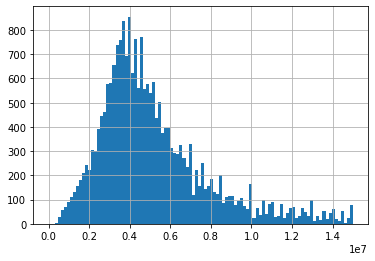

In [64]:
# Построим гистаграмму стоимости квартир
df['last_price'].hist(bins=100, range=(0,15000000))
df['last_price'].describe()

График выглядит вполне правдоподобно.
Квартиры стоимостью 3.4 - 6.8 млн. рублей составляют основной костяк всех объявлений. А вот квартиры стоимостью 12 млн являются аномально дорогими в нашей выборке - выбросы.

#### Число комнат

In [65]:
df['rooms'].describe()

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

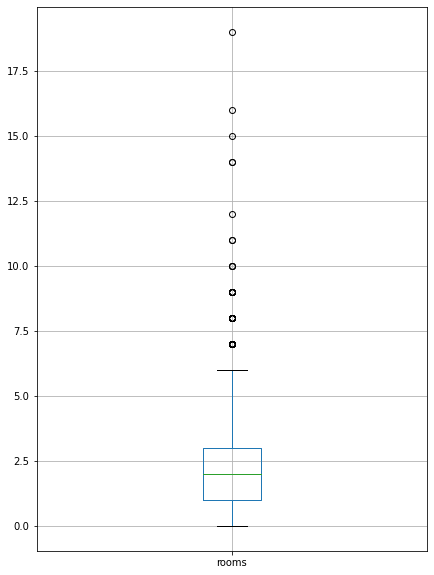

In [66]:
df.boxplot(column='rooms', figsize=(7,10))
plt.show()

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

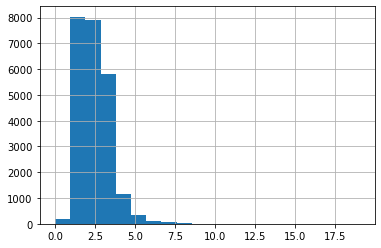

In [67]:
#Построим гистограмму количества комнат
df['rooms'].hist(bins = 20)
df['rooms'].describe()

Квартира c 19 комнатами, ошибка или эксклюзив? Проверим.

In [68]:
df.query("rooms > 7").sort_values(by = 'rooms', ascending = False)

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio
14498,Санкт-Петербург,264.5,27.6,374.6,19,2.55,32250000.0,0,2,5.0,False,False,False,2018-06-09,114.0,3574,19497,0,NaN,2.0,548,6,86092,5,6,2018,другой,0.71,0.07
18848,Санкт-Петербург,180.0,13.0,270.0,16,3.00,28500000.0,1,4,4.0,False,False,False,2015-03-02,1365.0,4142,23575,1,516.0,0.0,<NA>,6,105556,0,3,2015,последний,0.67,0.05
5358,Санкт-Петербург,409.0,100.0,590.0,15,3.50,65000000.0,0,3,6.0,False,False,False,2019-02-14,14.0,4666,24447,1,767.0,0.0,<NA>,20,110169,3,2,2019,другой,0.69,0.17
866,Санкт-Петербург,222.0,16.6,363.0,14,3.16,25000000.0,0,4,5.0,False,False,False,2017-12-23,418.0,7950,38076,0,NaN,2.0,435,5,68871,5,12,2017,другой,0.61,0.05
20829,Санкт-Петербург,168.3,25.9,245.4,14,3.00,28659000.0,0,2,4.0,False,False,False,2016-03-31,95.0,2054,21104,3,541.0,2.0,118,6,116785,3,3,2016,другой,0.69,0.11
19540,Санкт-Петербург,409.7,112.0,900.0,12,2.80,420000000.0,0,25,25.0,False,False,False,2017-12-06,106.0,7877,30706,0,NaN,2.0,318,8,466667,2,12,2017,последний,0.46,0.12
648,Санкт-Петербург,138.8,13.3,183.7,11,3.40,17500000.0,0,7,7.0,False,False,False,2018-07-01,NaN,3148,23606,0,NaN,0.0,<NA>,3,95264,6,7,2018,последний,0.76,0.07
9688,Санкт-Петербург,129.0,11.9,194.1,11,3.43,33000000.0,0,2,5.0,False,False,False,2017-02-07,813.0,1015,21469,1,686.0,2.0,66,8,170015,1,2,2017,другой,0.66,0.06
4149,Санкт-Петербург,145.9,18.8,272.6,10,3.14,23000000.0,1,7,7.0,False,False,False,2018-01-11,NaN,12169,10726,1,191.0,1.0,531,6,84373,3,1,2018,последний,0.54,0.07
18891,Санкт-Петербург,189.4,30.0,290.0,10,3.50,40000000.0,1,6,6.0,False,False,False,2016-06-21,77.0,4932,26229,3,316.0,1.0,227,11,137931,1,6,2016,последний,0.65,0.10


Это не ошибка, а уникальное предложение. Есть квартиры с 19, 16, 15 комнатами. Их мало, но они реальны.
В нашем исследовании предложения с количеством комнат больше 7 будут выбросами.

Квартиры со значением 0 в столбце комнаты стоит изучить внимательнее.
В идеале, так должны быть отмечены только квартиры-студии.

In [69]:
df.query("rooms == 0").sort_values(by = 'total_area', ascending = False)

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio
19392,Санкт-Петербург,NaN,NaN,371.0,0,3.57,71000000.0,0,6,7.0,False,False,True,2018-07-26,90.0,6060,25257,1,761.0,1.0,584,5,191375,3,7,2018,другой,NaN,NaN
20082,Санкт-Петербург,60.5,37.9,98.4,0,3.10,16300000.0,0,2,5.0,False,True,False,2017-11-08,537.0,5819,26972,0,NaN,1.0,674,10,165650,2,11,2017,другой,0.61,0.39
3458,Санкт-Петербург,50.0,23.6,73.6,0,2.80,7400000.0,0,1,3.0,False,True,False,2017-05-18,60.0,6085,26581,0,NaN,1.0,348,6,100543,3,5,2017,первый,0.68,0.32
21227,Санкт-Петербург,68.0,3.0,71.0,0,5.80,8200000.0,0,5,5.0,False,True,False,2017-07-21,30.0,1261,20170,2,295.0,3.0,366,0,115493,4,7,2017,последний,0.96,0.04
13613,Санкт-Петербург,33.0,25.4,58.4,0,3.30,8100000.0,0,6,7.0,False,True,False,2019-04-26,NaN,8288,14509,0,NaN,0.0,<NA>,16,138699,4,4,2019,другой,0.57,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,Санкт-Петербург,15.8,3.0,18.8,0,2.75,1350000.0,0,1,19.0,False,True,False,2017-11-22,128.0,14479,37636,0,NaN,1.0,1127,1,71809,2,11,2017,первый,0.84,0.16
12996,Санкт-Петербург,16.0,2.0,18.0,0,2.60,1900000.0,0,3,5.0,False,True,False,2019-01-25,10.0,15772,19573,2,149.0,2.0,496,8,105556,4,1,2019,другой,0.89,0.11
716,посёлок Шушары,12.0,5.0,17.0,0,2.70,1500000.0,0,1,9.0,False,True,False,2017-06-07,40.0,29846,18654,0,NaN,0.0,<NA>,5,88235,2,6,2017,первый,0.71,0.29
9412,Санкт-Петербург,13.0,3.0,16.0,0,3.00,2100000.0,0,1,6.0,False,False,True,2017-12-10,3.0,2111,20735,2,228.0,3.0,72,5,131250,6,12,2017,первый,0.81,0.19


Часть квартир являются квартирами-студиями, что логично. Но не у всех студий столбец studio = True. Скорректируем. 

А вот квартиры с площадью 50 кв. м и больше, вероятнее всего, имеют больше одной комнаты, но авторы объявления не заполнили данную графу. Мы не знаем сколько точно комнат в данных квартирах может быть, поэтому удалим эти строки, так как они будут влиять на итоговые выводы о влиянии количества комнат на стоимость.

In [70]:
df = df.loc[~((df['total_area'] >= 35) & (df['rooms'] == 0.0)), :]

In [71]:
df.query("rooms == 0").sort_values(by='total_area', ascending=False)

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio
508,посёлок Парголово,24.3,10.1,34.4,0,2.66,3375000.0,1,19,26.0,False,False,True,2017-03-28,430.0,19292,53115,0,NaN,1.0,593,0,98110,1,3,2017,другой,0.71,0.29
21628,Санкт-Петербург,24.0,10.0,34.0,0,2.75,3900000.0,2,10,20.0,False,False,True,2017-03-18,320.0,13615,15506,0,NaN,1.0,767,9,114706,5,3,2017,другой,0.71,0.29
16521,Санкт-Петербург,23.2,9.6,32.8,0,2.80,3600000.0,1,4,16.0,False,True,False,2017-07-17,169.0,16139,49888,1,472.0,0.0,<NA>,13,109756,0,7,2017,другой,0.71,0.29
18132,Санкт-Петербург,22.9,9.6,32.5,0,2.80,4800000.0,2,5,17.0,False,True,False,2019-04-09,NaN,13576,43996,1,396.0,0.0,<NA>,6,147692,1,4,2019,другой,0.70,0.30
12229,Санкт-Петербург,18.3,14.1,32.4,0,3.00,6200000.0,2,3,9.0,False,True,False,2018-02-22,32.0,4823,25987,0,NaN,2.0,849,12,191358,3,2,2018,другой,0.56,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,Санкт-Петербург,15.8,3.0,18.8,0,2.75,1350000.0,0,1,19.0,False,True,False,2017-11-22,128.0,14479,37636,0,NaN,1.0,1127,1,71809,2,11,2017,первый,0.84,0.16
12996,Санкт-Петербург,16.0,2.0,18.0,0,2.60,1900000.0,0,3,5.0,False,True,False,2019-01-25,10.0,15772,19573,2,149.0,2.0,496,8,105556,4,1,2019,другой,0.89,0.11
716,посёлок Шушары,12.0,5.0,17.0,0,2.70,1500000.0,0,1,9.0,False,True,False,2017-06-07,40.0,29846,18654,0,NaN,0.0,<NA>,5,88235,2,6,2017,первый,0.71,0.29
9412,Санкт-Петербург,13.0,3.0,16.0,0,3.00,2100000.0,0,1,6.0,False,False,True,2017-12-10,3.0,2111,20735,2,228.0,3.0,72,5,131250,6,12,2017,первый,0.81,0.19


Мы удалили 12 строк, зато наши данные стали более корректны.

#### Высота потолков

In [72]:
df['ceiling_height'].describe()

count    23638.000000
mean         2.709006
std          0.264315
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max         14.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

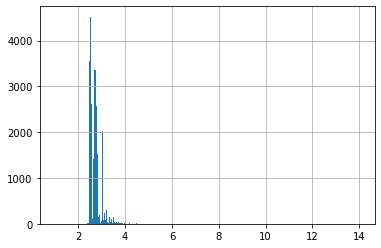

In [73]:
#Исследуем высоту потолков
df['ceiling_height'].hist(bins = 300)

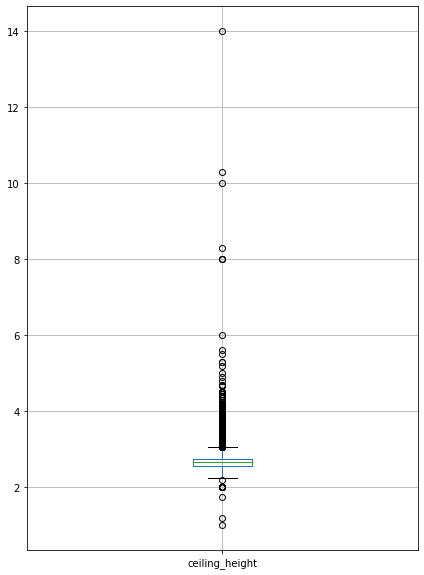

In [74]:
df.boxplot(column='ceiling_height', figsize=(7,10))
plt.show()

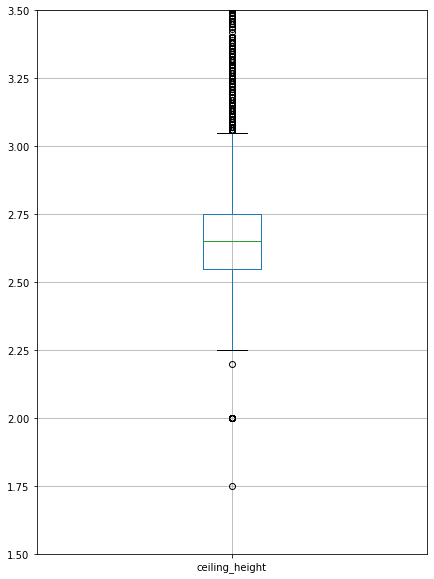

In [75]:
df.boxplot(column='ceiling_height', figsize=(7,10))
plt.ylim(1.5,3.5)
plt.show()

<AxesSubplot:>

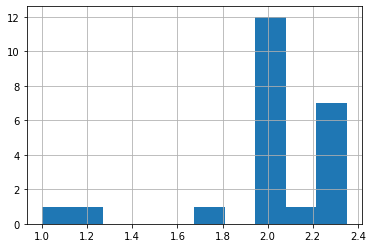

In [76]:
# Посмотрим самые минимальные значения поближе
df['ceiling_height'].hist(bins = 10, range=(1, 2.35))

<AxesSubplot:>

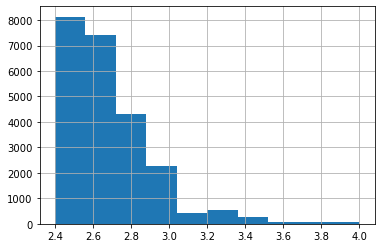

In [77]:
# Посмотрим самые частые значения поближе
df['ceiling_height'].hist(range=(2.4, 4), bins = 10)

Будем считать, что высота потолков ниже 2.25 м является некорректно заполненной, так как объктивно это очень низкие потолки и по факту таких значений единицы, что выброс. Как и квартиры с высотою потолков выше 3.05 м.


Средняя высота потолков на рынке недвижимости в Санкт-Петербурге и соседних населённых пунктах 2.55 - 2.75 м.

<AxesSubplot:>

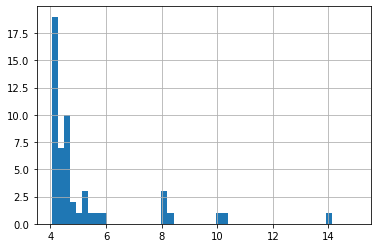

In [78]:
# Посмотрим максимальные значения поближе
df['ceiling_height'].hist(range=(4.05, 15), bins = 50)

Значения высоты потолков меньше 2 м и больше 5 м являются выбросами.

От таких строк нужно избавиться, чтобы результаты анализа были более корректны.

In [79]:
df = df.loc[~((df['ceiling_height'] <= 1.95)),:]

In [80]:
df = df.loc[~((df['ceiling_height'] >= 5)),:]

In [81]:
df.sort_values(by='ceiling_height', ascending=False)

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio
21923,Санкт-Петербург,140.0,50.0,235.0,5,4.90,115490000.0,0,5,5.0,False,False,False,2017-04-09,351.0,1328,22777,3,652.0,3.0,253,10,491447,6,4,2017,последний,0.60,0.21
2802,Санкт-Петербург,30.0,10.0,50.0,2,4.80,14950000.0,0,2,3.0,False,False,False,2016-03-06,160.0,1725,24433,1,589.0,3.0,161,7,299000,6,3,2016,другой,0.60,0.20
19142,Санкт-Петербург,57.4,25.0,87.7,2,4.70,8650000.0,2,26,26.0,False,False,False,2017-07-18,15.0,9888,40648,1,1248.0,0.0,<NA>,10,98632,1,7,2017,последний,0.65,0.29
1300,Санкт-Петербург,162.0,30.0,280.0,5,4.70,120000000.0,0,3,4.0,False,False,False,2018-07-12,225.0,4247,24680,1,464.0,3.0,339,14,428571,3,7,2018,другой,0.58,0.11
12401,Санкт-Петербург,347.5,25.0,495.0,7,4.65,91500000.0,0,7,7.0,False,False,False,2017-06-19,14.0,5735,<NA>,2,110.0,0.0,<NA>,20,184848,0,6,2017,последний,0.70,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Санкт-Петербург,17.5,6.5,33.5,1,2.00,2999000.0,0,6,15.0,False,False,False,2017-03-30,270.0,11746,33972,1,520.0,1.0,949,11,89522,3,3,2017,другой,0.52,0.19
16446,Санкт-Петербург,63.9,12.0,88.3,3,2.00,12300000.0,0,2,5.0,False,False,False,2019-03-12,NaN,7675,38415,1,568.0,1.0,154,6,139298,1,3,2019,другой,0.72,0.14
11352,посёлок Металлострой,15.2,10.1,36.0,1,2.00,3300000.0,0,12,17.0,False,False,False,2017-06-18,53.0,26980,25268,0,NaN,0.0,<NA>,4,91667,6,6,2017,другой,0.42,0.28
19329,Сосновый Бор,NaN,NaN,40.0,2,2.00,1700000.0,0,8,9.0,False,False,False,2018-07-15,45.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,5,42500,6,7,2018,другой,NaN,NaN


In [82]:
#Проверим, остались ли пустые значения
df['ceiling_height'].isna().sum()

0

### Изучение времени продажи квартиры

In [83]:
df['days_exposition'].describe()

count    20444.000000
mean       180.744326
std        219.797535
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

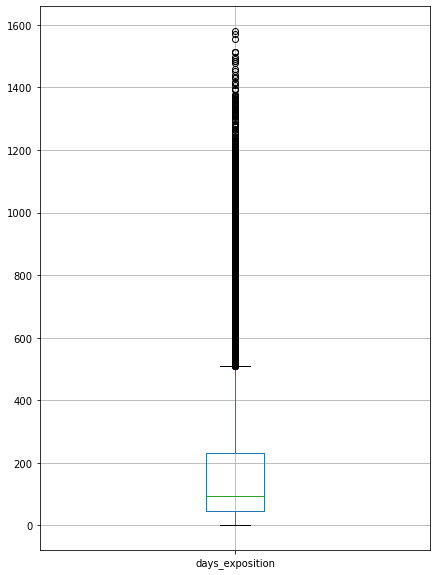

In [84]:
df.boxplot(column='days_exposition', figsize=(7,10))
plt.show()

<AxesSubplot:>

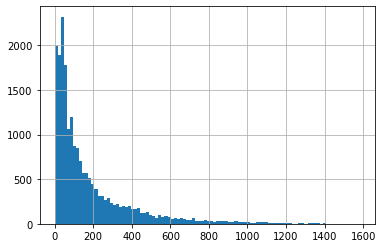

In [85]:
df['days_exposition'].hist(bins=100)

В целом гистограмма имеет нормальный вид распределения Пуассона, с большим хвостом выбросы. Но наблюдаются нетипичные пики.\
Посмотрим поближе.

<AxesSubplot:>

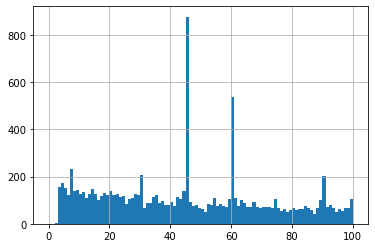

In [86]:
df['days_exposition'].hist(bins=100, range=(0,100))

Да, количество продаж в определенные дни явно выбивается из общей равномерной картины. Посмотрим, что это за дни.

In [87]:
# Посмотрим, в какой день подачи объявления эти пики
df['days_exposition'].value_counts()

45.0      878
60.0      537
7.0       233
30.0      206
90.0      202
         ... 
969.0       1
1.0         1
1147.0      1
1148.0      1
1174.0      1
Name: days_exposition, Length: 1141, dtype: int64

В 7, 30, 45, 60 и 90 дни подачи объявления мы видим скачки продаж.
Было бы очень странно, если бы все дружно покупали квартиру на 45 день подачи объявления. Это больше похоже на какую-то техническую особенность интернет-площадки, типа "снятия с продажи" в определенный день (через неделю, месяц, квартал).

Если не брать во внимание эти пики, то мы видим, что обычно квартиры продаются за 90 дней.
Четверть квартир была продана всего за 45 дней.

Нормальным будем считать период 45 - 231 день, именно такими цифррами ограничен межквартальный размах.
Ориентируясь на пределы нормальных значений, мы можем судить о скорости продаж. У нас нет данных считать, что продажи прошли очень быстро, так как нижняя граница это 1 день, но можем сказать, что квартира продавалась необычно долго, если объявлению больше 510 дней. Если же нижний порог принять за значение 1го квантиля, то квартиры проданные за 45 дней это быстрые продажи.

### Выявление и удаление редких и выбивающихся значений

На предыдущем этапе изучения датасета мы обнаружили редкие и выбивающиеся значения.

Например, объект недвижимости площадью 900 кв. м, что в 17 раз больше медианного значения и почти в 8 раз больше верхнего предела нормальных значений.
Была обнаружена квартира площадью 109 кв. м в Санкт-Петербурге с указанной ценой 12190 рублей и ценой за метр 112 рублей. Это была ошибка и мы исправили данные. Квартиры стоимостью 12 млн. рублей оказались аномально дорогими в нашей выборке.

Также мы изучили, что продаются квартиры с 19, 16, 15 комнатами. Их мало, но они реальны.
В нашем исследовании предложения с количеством комнат больше 6 являются выбивающимися значениями.

Средняя высота потолков на рынке недвижимости в Санкт-Петербурге и соседних населённых пунктах 2.55 - 2.75 м, а всё, что ниже или выше этих значений тоже является аномальным.

Чтобы убрать редкие и выбивающиеся значения нам нужно сделать еще несколько шагов: определить нормальные значения, добавить в исходный датасет соотвветствующие данные и отфильтровав по ним создать новую таблицу без аномалий.

Для начала напишем функцию, которая будет определять границы "усов" интересующего нас параметра квартиры.

In [88]:
def whiskers(column):
    table = df[column].describe()
    
    # Нормальные значения составляют межквартирльный размах (строки 25% и 75%):
    normal_values = table[6] - table[4]
    
    # Левый и правый ус значений изучаемого параметра:
    left_whisker = round(table[4] - 1.5*normal_values, 2)
    right_whisker = round(table[6] + 1.5*normal_values, 2)
    
    # Левый ус не должен быть меньше минимального значения:
    if left_whisker < table[3]: left_whisker = table[3] 
        
    # Правый ус не должен быть больше максимального значения:
    if right_whisker > table[7]: right_whisker = table[7]
        
    return [left_whisker, right_whisker]

In [90]:
# Добавим столбцы характеризующие является параметр нормальным или аномальным
df['anomalous_area'] = df['total_area'] > whiskers('total_area')[1]
df['anomalous_price'] = df['last_price'] > whiskers('last_price')[1]
df['anomalous_rooms'] = df['rooms'] > whiskers('rooms')[1]
df['anomalous_ceiling'] = (df['ceiling_height'] > whiskers('ceiling_height')[1]) | (df['ceiling_height'] < whiskers('ceiling_height')[0])
df['too_slow'] = df['days_exposition'] > whiskers('days_exposition')[1]
df['too_fast'] = df['days_exposition'] < 45 #45 дней мы решили считать быстрой продажей

In [91]:
df.head()

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio,anomalous_area,anomalous_price,anomalous_rooms,anomalous_ceiling,too_slow,too_fast
0,Санкт-Петербург,51.0,25.0,108.0,3,2.70,13000000.0,0,8,16.0,False,False,False,2019-03-07,NaN,16028,18863,1,482.0,2.0,755,20,120370,3,3,2019,другой,0.47,0.23,False,True,False,False,False,False
1,посёлок Шушары,18.6,11.0,40.4,1,2.75,3350000.0,2,1,11.0,False,False,False,2018-12-04,81.0,18603,12817,0,NaN,0.0,<NA>,7,82921,1,12,2018,первый,0.46,0.27,False,False,False,False,False,False
2,Санкт-Петербург,34.3,8.3,56.0,2,2.55,5196000.0,0,4,5.0,False,False,False,2015-08-20,558.0,13933,21741,1,90.0,2.0,574,10,92786,3,8,2015,другой,0.61,0.15,False,False,False,False,True,False
3,Санкт-Петербург,NaN,NaN,159.0,3,2.60,64900000.0,0,9,14.0,False,False,False,2015-07-24,424.0,6800,28098,2,84.0,3.0,234,0,408176,4,7,2015,другой,NaN,NaN,True,True,False,False,False,False
4,Санкт-Петербург,32.0,41.0,100.0,2,3.03,10000000.0,0,13,14.0,False,False,False,2018-06-19,121.0,8098,31856,2,112.0,1.0,48,2,100000,1,6,2018,другой,0.32,0.41,False,False,False,False,False,False


In [92]:
# Cоздадим новый датасет, удалив из старого редкие и выбивающиеся значения
# Используем параметр drop, чтобы избежать добавления старого индекса в качестве столбца
normal_df = df[(df['anomalous_area'] == False) & 
               (df['anomalous_price'] == False) & 
               (df['anomalous_rooms'] == False) & 
               (df['anomalous_ceiling'] == False) & 
               (df['too_slow'] == False) &
               (df['too_fast'] == False)].reset_index(drop=True)

In [93]:
normal_df.head()

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio,anomalous_area,anomalous_price,anomalous_rooms,anomalous_ceiling,too_slow,too_fast
0,посёлок Шушары,18.6,11.0,40.4,1,2.75,3350000.0,2,1,11.0,False,False,False,2018-12-04,81.0,18603,12817,0,NaN,0.0,<NA>,7,82921,1,12,2018,первый,0.46,0.27,False,False,False,False,False,False
1,Санкт-Петербург,32.0,41.0,100.0,2,3.03,10000000.0,0,13,14.0,False,False,False,2018-06-19,121.0,8098,31856,2,112.0,1.0,48,2,100000,1,6,2018,другой,0.32,0.41,False,False,False,False,False,False
2,городской посёлок Янино-1,14.4,9.1,30.4,1,2.65,2890000.0,0,5,12.0,False,False,False,2018-09-10,55.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,10,95066,0,9,2018,другой,0.47,0.30,False,False,False,False,False,False
3,посёлок Парголово,10.6,14.4,37.3,1,2.66,3700000.0,1,6,26.0,False,False,False,2017-11-02,155.0,19143,52996,0,NaN,0.0,<NA>,6,99196,3,11,2017,другой,0.28,0.39,False,False,False,False,False,False
4,Санкт-Петербург,52.7,18.9,71.6,2,2.75,7915000.0,2,22,24.0,False,False,False,2019-04-18,NaN,11634,23982,0,NaN,0.0,<NA>,5,110545,3,4,2019,другой,0.74,0.26,False,False,False,False,False,False


### Выявление факторов больше всего влияющих на стоимость квартиры

Изучим, зависит ли цена от площади, числа комнат, удалённости от центра.\
Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом.\
Также изучим зависимость от даты размещения: дня недели, месяца и года

In [94]:
# Создадим датасет только интересующих нас в этом исследовании параметров
corr_df = normal_df[['total_area', 'rooms', 'cityCenters_nearest', 'price_for_meter']]

In [95]:
corr_df.head()

,total_area,rooms,cityCenters_nearest,price_for_meter
0,40.4,1,18603,82921
1,100.0,2,8098,100000
2,30.4,1,<NA>,95066
3,37.3,1,19143,99196
4,71.6,2,11634,110545


In [96]:
corr_df.corr().round(2)

,total_area,rooms,cityCenters_nearest,price_for_meter
total_area,1.00,0.80,-0.08,-0.07
rooms,0.80,1.00,-0.05,-0.23
cityCenters_nearest,-0.08,-0.05,1.00,-0.40
price_for_meter,-0.07,-0.23,-0.40,1.00


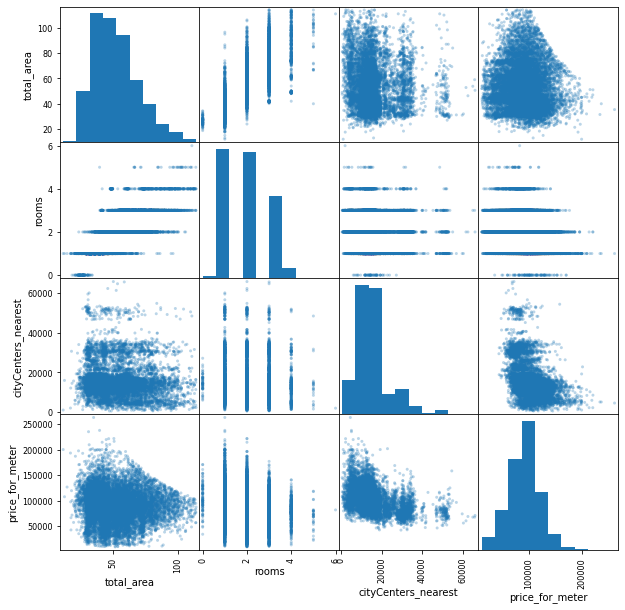

In [97]:
# Построим диаграмму рассеяния
pd.plotting.scatter_matrix(corr_df, figsize=(10,10), alpha=0.3)
plt.ticklabel_format(useOffset=False)

Text(0.5, 1.0, 'Зависимость цены от количества комнат')

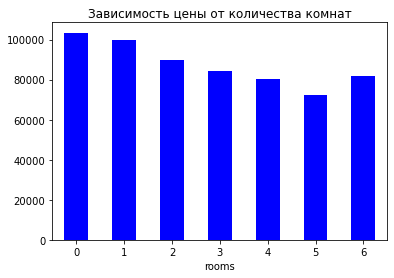

In [98]:
floor_df = normal_df.groupby('rooms')['price_for_meter'].median()
floor_df.plot(y='median', kind='bar', color="b")
plt.xticks(rotation=0)
plt.title('Зависимость цены от количества комнат')

Из имеющихся данных мы видим, что:

* Зависимость цены квартиры от её площади отрицательная, но очень слабая — согласно корреляции Пирсона -0.07. То есть, чем больше площадь тем стоимость квадратного метра чуть ниже. Это вполне опрадано, ведь "оптом дешевле".
* В целом, зависимость стоимости квадратного метра квартиры от количества комнат тоже слабо отрицательная, но чуть более выраженная — согласно корреляции Пирсона -0.23. А если посмотреть детально, то мы увидим, что квартиры-студии и однокомнатные самые дорогие на рынке, а вот 4-5-6 комнатные ощутимо дешевле.
* Зависимость цены квартиры от её удаленности от центра отрицательная, но самая весомая — согласно корреляции Пирсона -0.40. Чем дальше от центра, тем квартиры стоят дешевле, что вполне логично.

Text(0.5, 1.0, 'Зависимость цены от категории этажа')

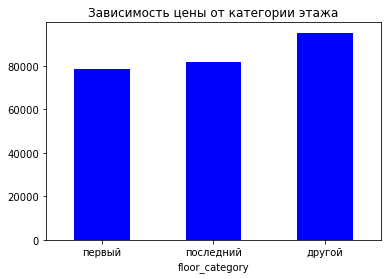

In [99]:
# Построим диаграмму зависимости категории этажа на стоимость квартиры
floor_df = normal_df.groupby('floor_category')['price_for_meter'].median().sort_values()
floor_df.plot(y='median', kind='bar', color="b")
plt.xticks(rotation=0)
plt.title('Зависимость цены от категории этажа')

Самые дешевые квартиры расположены на первых этажах, чуть дороже квартиры на последних этажах, на остальных - самые дорогие.

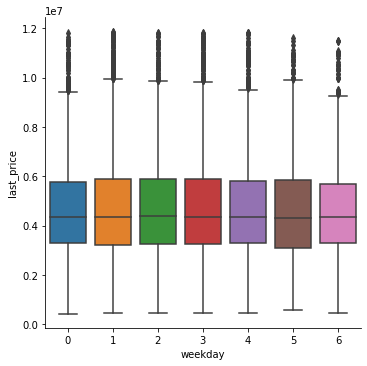

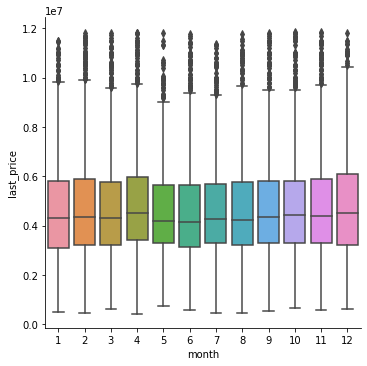

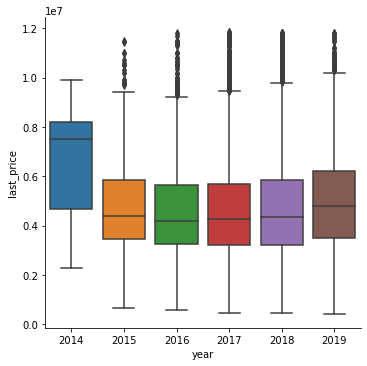

In [100]:
# Изучим зависимость от даты размещения: дня недели, месяца и года
for column in ['weekday', 'month', 'year']:
    sns.catplot(data=normal_df, x=column, y="last_price", kind="box")

Мы видим, что день недели никак не влияет на стоимость квартиры.\
Квартиры в апреле и декабре стоят дороже, чем в остальные месяцы. А в июне дешевле всего.\
С каждым годом недвижимость дорожает, что вполне логично. Вот только данные за 2014 год стоит проверить, слишком этот год выделяется на фоне остальных, возможно слишком маленькая выборка и данные нерепрезентативны.

In [101]:
# Уточним объем выборки по годам
df['year'].value_counts()

2018    8501
2017    8172
2019    2878
2016    2764
2015    1170
2014     136
Name: year, dtype: int64

Как и предполагалось, за 2014 год имеется слишком мало данных, чтобы делать какие-либо полноценные выводы.

### Изучение 10 населённых пунктов с наибольшим числом объявлений

Составим Топ-10 населённых пунктов с наибольшим числом объявлений.\
Посчитаем среднюю цену квадратного метра в этих населённых пунктах.\
Выделим населённые пункты с самой высокой и низкой стоимостью жилья.

In [102]:
locality_pivot_table = normal_df.pivot_table(index='locality_name', values='price_for_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values(by='count', ascending=False).round().head(10)
locality_pivot_table

,count,mean
locality_name,,
Санкт-Петербург,8844,105463.0
посёлок Мурино,332,85066.0
посёлок Шушары,320,78926.0
Всеволожск,295,67277.0
Пушкин,241,99470.0
посёлок Парголово,237,89989.0
Колпино,227,74923.0
Гатчина,221,67969.0
деревня Кудрово,187,92360.0


<AxesSubplot:xlabel='locality_name'>

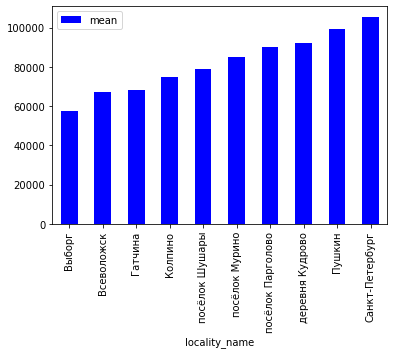

In [103]:
(
    locality_pivot_table.
    sort_values(by='mean').
    plot(y='mean', kind='bar', color='b')
)

In [104]:
# Найдем максимальное значение стоимости квартиры
locality_pivot_table[locality_pivot_table['mean'] == locality_pivot_table['mean'].max()]

,count,mean
locality_name,,
Санкт-Петербург,8844,105463.0


In [105]:
# Найдем минимальное значение стоимости квартиры
locality_pivot_table[locality_pivot_table['mean'] == locality_pivot_table['mean'].min()]

,count,mean
locality_name,,
Выборг,162,57337.0


Самая высокая стоимость квадратного метра жилья в Санкт-Петеребурге, а самая низкая наблюдается в Выборге.

### Изучение, как цена квартир зависит от удалённости от центра

Изучим предложения квартир: для каждой квартиры есть информация о расстоянии до центра.

Выделим квартиры в Санкт-Петербурге. Главная задача — выяснить, какая область входит в центр.

Создадим столбец с расстоянием до центра в километрах: округлим до целых значений. После этого посчитаем среднюю цену для каждого километра.

Построим график: он будет показывать, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется, — это и будет центральная зона.

In [106]:
# Создадим столбец с расстоянием до центра в километрах: округлим до целых значений
normal_df['cityCenters_nearest_km'] = (normal_df['cityCenters_nearest'] // 1000)

In [107]:
normal_df.head()

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio,anomalous_area,anomalous_price,anomalous_rooms,anomalous_ceiling,too_slow,too_fast,cityCenters_nearest_km
0,посёлок Шушары,18.6,11.0,40.4,1,2.75,3350000.0,2,1,11.0,False,False,False,2018-12-04,81.0,18603,12817,0,NaN,0.0,<NA>,7,82921,1,12,2018,первый,0.46,0.27,False,False,False,False,False,False,18
1,Санкт-Петербург,32.0,41.0,100.0,2,3.03,10000000.0,0,13,14.0,False,False,False,2018-06-19,121.0,8098,31856,2,112.0,1.0,48,2,100000,1,6,2018,другой,0.32,0.41,False,False,False,False,False,False,8
2,городской посёлок Янино-1,14.4,9.1,30.4,1,2.65,2890000.0,0,5,12.0,False,False,False,2018-09-10,55.0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,10,95066,0,9,2018,другой,0.47,0.30,False,False,False,False,False,False,<NA>
3,посёлок Парголово,10.6,14.4,37.3,1,2.66,3700000.0,1,6,26.0,False,False,False,2017-11-02,155.0,19143,52996,0,NaN,0.0,<NA>,6,99196,3,11,2017,другой,0.28,0.39,False,False,False,False,False,False,19
4,Санкт-Петербург,52.7,18.9,71.6,2,2.75,7915000.0,2,22,24.0,False,False,False,2019-04-18,NaN,11634,23982,0,NaN,0.0,<NA>,5,110545,3,4,2019,другой,0.74,0.26,False,False,False,False,False,False,11


<AxesSubplot:xlabel='cityCenters_nearest_km', ylabel='price_for_meter'>

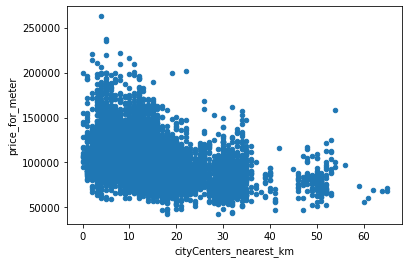

In [108]:
normal_df.plot(x='cityCenters_nearest_km', y='price_for_meter', kind='scatter')

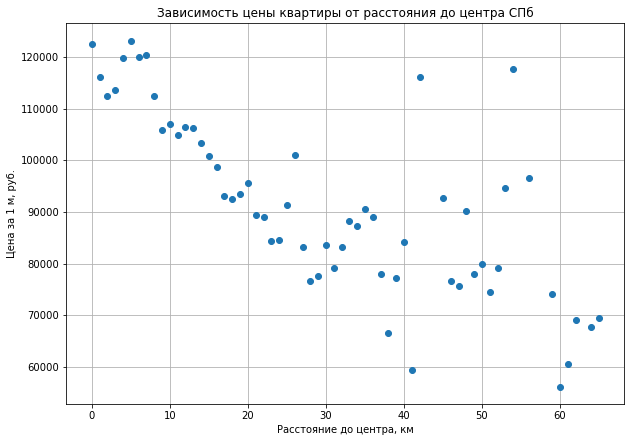

In [109]:
# Выделим квартиры в Санкт-Петербурге
normal_df.groupby('cityCenters_nearest_km')['price_for_meter'].mean().round().plot(style='o', figsize = (10,7), grid=True)
plt.title('Зависимость цены квартиры от расстояния до центра СПб')
plt.ylabel('Цена за 1 м, руб.')
plt.xlabel('Расстояние до центра, км')
plt.show()

Наиболее выраженный перепад значений между значениями удаленности от центра на 8 и 9 км (разница около 10%).

Примем границу центральной зоны 8 км (включительно).

### Изучение сегмента квартир в центре

Выделим сегмент квартир в центре.

Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков.
    
Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).

Сделаем выводы. Посмотрим, отличаются ли они от общих выводов по всему городу.

In [110]:
# Отфильтруем по расстоянию центр
center_df = normal_df.loc[(normal_df['cityCenters_nearest_km'] <= 8) & (normal_df['locality_name'] == 'Санкт-Петербург'),:]
center_df.head()

,locality_name,living_area,kitchen_area,total_area,rooms,ceiling_height,last_price,balcony,floor,floors_total,is_apartment,studio,open_plan,first_day_exposition,days_exposition,cityCenters_nearest,airports_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,price_for_meter,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio,anomalous_area,anomalous_price,anomalous_rooms,anomalous_ceiling,too_slow,too_fast,cityCenters_nearest_km
1,Санкт-Петербург,32.0,41.0,100.0,2,3.03,10000000.0,0,13,14.0,False,False,False,2018-06-19,121.0,8098,31856,2,112.0,1.0,48,2,100000,1,6,2018,другой,0.32,0.41,False,False,False,False,False,False,8
16,Санкт-Петербург,46.5,19.6,97.2,2,2.80,6500000.0,0,1,3.0,False,False,False,2015-10-31,265.0,2336,20052,3,411.0,3.0,124,8,66872,5,10,2015,первый,0.48,0.20,False,False,False,False,False,False,2
68,Санкт-Петербург,67.0,8.0,90.0,4,2.55,9600000.0,0,2,5.0,False,False,False,2017-09-26,104.0,2818,23277,0,NaN,0.0,<NA>,32,106667,1,9,2017,другой,0.74,0.09,False,False,False,False,False,False,2
78,Санкт-Петербург,8.3,6.3,21.4,1,2.90,4000000.0,0,7,8.0,False,False,False,2019-02-07,NaN,5791,27089,2,488.0,1.0,286,5,186916,3,2,2019,другой,0.39,0.29,False,False,False,False,False,False,5
79,Санкт-Петербург,27.0,6.5,42.0,2,2.55,3850000.0,0,4,5.0,False,False,False,2018-11-05,73.0,8535,43019,0,NaN,0.0,<NA>,8,91667,0,11,2018,другой,0.64,0.15,False,False,False,False,False,False,8


In [111]:
#Оставим в таблице нужные нам параметры
center_corr_df = center_df[['total_area', 
                            'rooms', 
                            'ceiling_height', 
                            'cityCenters_nearest', 
                            'floor_category', 
                            'weekday', 'month', 'year', 
                            'price_for_meter']]
center_corr_df.head()

,total_area,rooms,ceiling_height,cityCenters_nearest,floor_category,weekday,month,year,price_for_meter
1,100.0,2,3.03,8098,другой,1,6,2018,100000
16,97.2,2,2.80,2336,первый,5,10,2015,66872
68,90.0,4,2.55,2818,другой,1,9,2017,106667
78,21.4,1,2.90,5791,другой,3,2,2019,186916
79,42.0,2,2.55,8535,другой,0,11,2018,91667


In [112]:
# Построим матрицу корреляции
center_corr_df.corr().round(2)

,total_area,rooms,ceiling_height,cityCenters_nearest,weekday,month,year,price_for_meter
total_area,1.00,0.80,0.23,-0.23,-0.01,0.04,-0.06,-0.37
rooms,0.80,1.00,0.16,-0.18,-0.01,0.04,-0.04,-0.47
ceiling_height,0.23,0.16,1.00,-0.22,0.03,-0.03,0.02,-0.02
cityCenters_nearest,-0.23,-0.18,-0.22,1.00,0.03,-0.03,0.08,-0.02
weekday,-0.01,-0.01,0.03,0.03,1.00,0.05,0.00,0.04
month,0.04,0.04,-0.03,-0.03,0.05,1.00,-0.29,-0.04
year,-0.06,-0.04,0.02,0.08,0.00,-0.29,1.00,0.17
price_for_meter,-0.37,-0.47,-0.02,-0.02,0.04,-0.04,0.17,1.00


<AxesSubplot:>

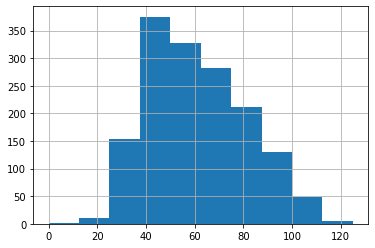

In [113]:
# Построим гистограмму предлагаемых площадей в квартирах центральной части
center_corr_df['total_area'].hist(bins=10, range=(0,125))

<AxesSubplot:>

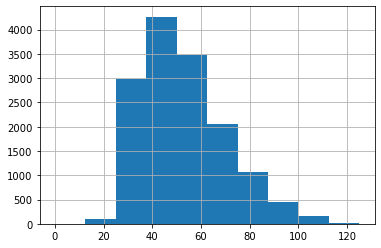

In [114]:
# Построим гистограмму предлагаемых площадей всего рынка квартир
normal_df['total_area'].hist(bins=10, range=(0,125))

In [115]:
center_corr_df['total_area'].corr(center_corr_df['price_for_meter'])

-0.37180952054688376

In [116]:
normal_df['total_area'].corr(normal_df['price_for_meter'])

-0.06872332012004838

Из расспределения площадей на гистограммах мы видим, что в центральной части больше доля квартир с площадью от 50 кв. м, а доля квартир с площадью до 40 кв. м меньше, чем на всем рынке недвижимости вместе.

Коэффициент корреляции в центре составляет -0,37 и это дает нам понять, что есть небольшая отрицательная зависимость — чем больше площадь квартиры, тем дешевле её квадратный метр. Общий коэф.корреляции равен всего -0.068, что гворит об отсутствии взаимосвязи.

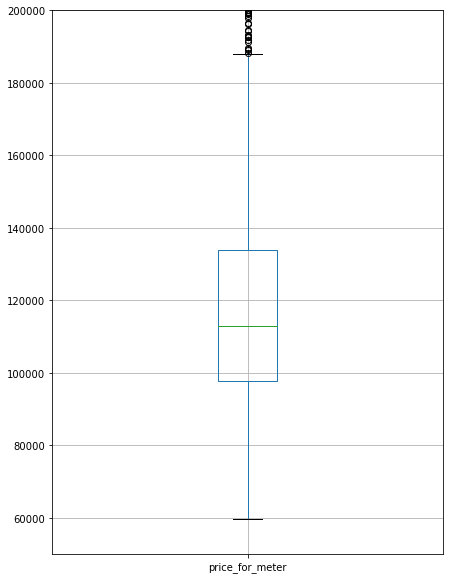

In [117]:
center_corr_df.boxplot(column='price_for_meter', figsize = (7,10))
plt.ylim(50000,200000)
plt.show()

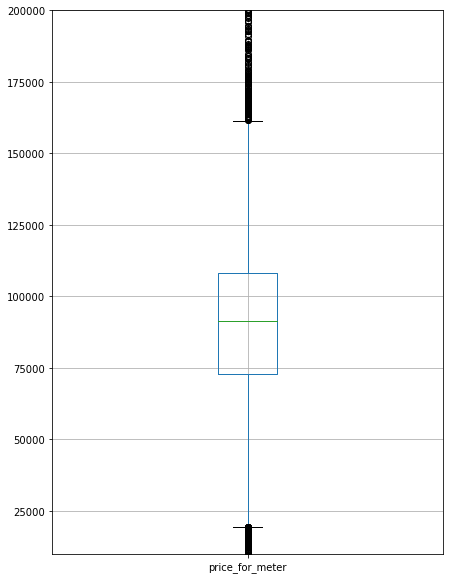

In [118]:
normal_df.boxplot(column='price_for_meter', figsize = (7,10))
plt.ylim(10000,200000)
plt.show()

Как мы видим, квартиры в центре дороже, об этом нам сообщают границы нормальных значений и межвартальный интервал и медианные значения. Это вполне соответствует законам рынка.

In [119]:
# Посмотрим как на цену квадратного метра в центре влияет количество комнат
# Создадим сводную таблицу средних значений в центральном сегменте и по рынку в целом
rooms_center_df = center_corr_df.pivot_table(index='rooms', values='price_for_meter', aggfunc='mean')
rooms_normal_df = normal_df.pivot_table(index='rooms', values='price_for_meter', aggfunc='mean')
compare_rooms = rooms_center_df.merge(rooms_normal_df, on='rooms')
compare_rooms.columns = ['center_pfm', 'all_pfm']
compare_rooms['center_pfm'] = compare_rooms['center_pfm'].astype('int64')
compare_rooms['all_pfm'] = compare_rooms['all_pfm'].astype('int64')
compare_rooms

,center_pfm,all_pfm
rooms,,
0,137845,106019
1,138148,98761
2,117043,88293
3,106141,82107
4,94841,78852
5,98963,69104
6,81982,81982


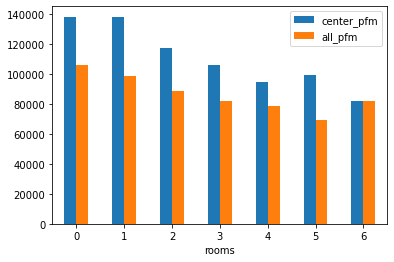

In [120]:
compare_rooms.groupby('rooms').sum().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

<AxesSubplot:>

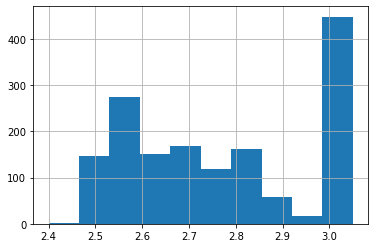

In [121]:
# Исследуем высоту потолков в центральной части
center_corr_df['ceiling_height'].hist(bins = 10)

<AxesSubplot:>

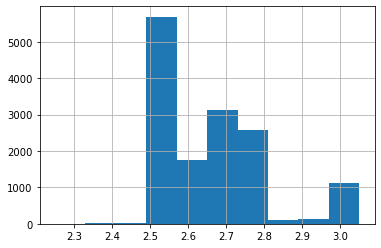

In [122]:
# Исследуем высоту потолков по рынку в целом
normal_df['ceiling_height'].hist(bins = 10)

Высота потолков в центре преимущественно 3 м, тогда как на всем рынке лидирует высота потолков 2,50-2,55 м.

Центр это дома старой застройки, сейчас дома с высотой потолков 3 метра строят крайне редко.

In [123]:
# Посмотрим, как на цену квадратного метра жилья в центре влияет этаж
# Создадим сводную таблицу средних значений в центральном сегменте и по рынку в целом
floor_center_df = center_corr_df.pivot_table(index='floor_category', values='price_for_meter', aggfunc='mean')
floor_normal_df = normal_df.pivot_table(index='floor_category', values='price_for_meter', aggfunc='mean')
compare_floors = floor_center_df.merge(floor_normal_df, on='floor_category')
compare_floors.columns = ['center_pfm', 'all_pfm']
compare_floors['center_pfm'] = compare_floors['center_pfm'].astype('int64')
compare_floors['all_pfm'] = compare_floors['all_pfm'].astype('int64')
compare_floors

,center_pfm,all_pfm
floor_category,,
другой,121416,94957
первый,106823,76688
последний,113214,80824


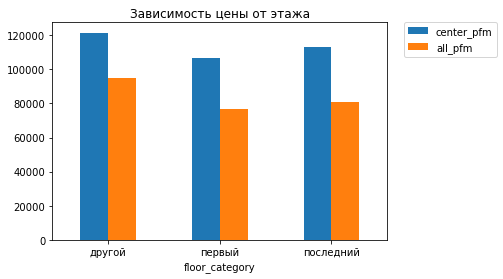

In [124]:
compare_floors.groupby('floor_category').sum().plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Зависимость цены от этажа')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# plt.legend(loc='lower center')
plt.show()

Как видим, этажность одинаково влияет на цену квадратного метра жилья в обоих исследуемых сегментаж.

<ipython-input-125-71a79918e20c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_corr_df['cityCenters_nearest_km'] = (center_corr_df['cityCenters_nearest'] / 1000).astype('int64')


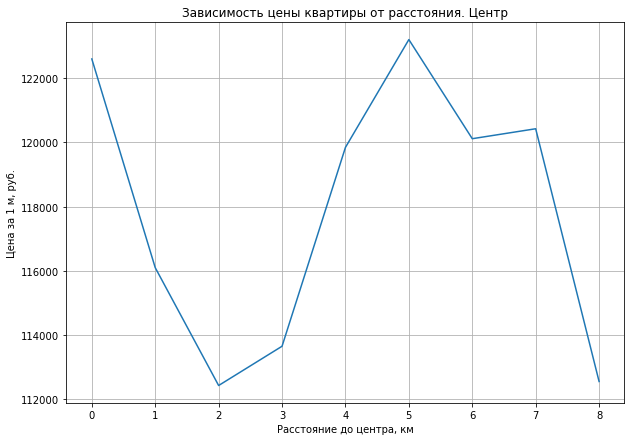

In [125]:
# Посмотрим, как влияет удаленность от центра на стоимость квадратного метра
center_corr_df['cityCenters_nearest_km'] = (center_corr_df['cityCenters_nearest'] / 1000).astype('int64')
center_corr_df.groupby('cityCenters_nearest_km')['price_for_meter'].mean().round().plot(figsize=(10,7), grid=True)
plt.title('Зависимость цены квартиры от расстояния. Центр')
plt.ylabel('Цена за 1 м, руб.')
plt.xlabel('Расстояние до центра, км')
plt.show()

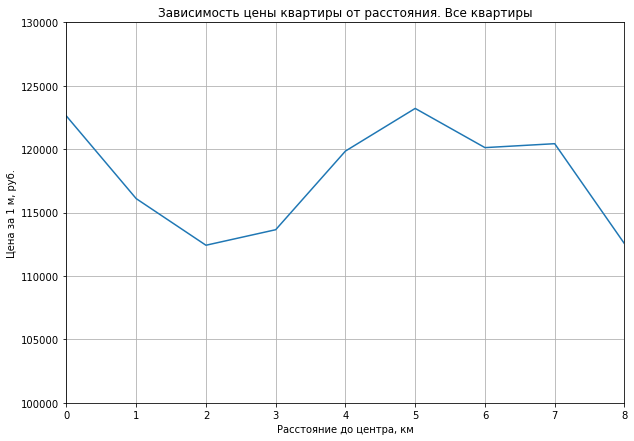

In [126]:
# Посмотрим, как влияет удаленность от центра на стоимость квадратного метра
normal_df['cityCenters_nearest_km'] = (normal_df['cityCenters_nearest'] // 1000)
normal_df.groupby('cityCenters_nearest_km')['price_for_meter'].mean().round().plot(figsize=(10,7), grid=True)
plt.title('Зависимость цены квартиры от расстояния. Все квартиры')
plt.ylabel('Цена за 1 м, руб.')
plt.xlabel('Расстояние до центра, км')
plt.xlim(0,8)
plt.ylim(100000,130000)
plt.show()

In [127]:
center_corr_df['cityCenters_nearest_km'].corr(center_corr_df['price_for_meter'])

-0.016932956624360566

In [132]:
normal_df['cityCenters_nearest_km'].corr(normal_df['price_for_meter'])

AttributeError: 'float' object has no attribute 'shape'

Цена кв. м имеет небольшую обратную зависимость от удаленности от центра для рынка вцелом, коэффициент корреляции составляет -0.40. Для рынка в целом этот коэффициент равен всего 0,04 и не играет роли.

Посмотрим влияние дня, месяца и года размещения объявления в центре и сравним с рынком в целом.

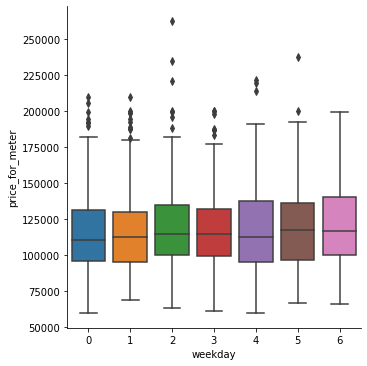

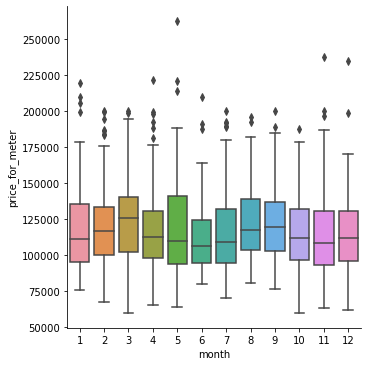

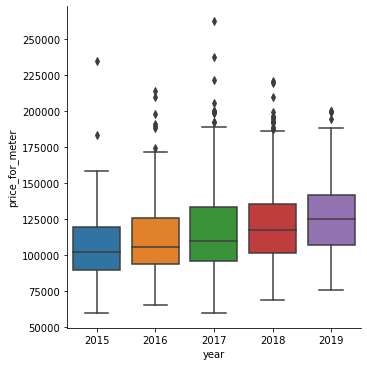

In [133]:
# Посмотрим влияние дня, месяца и года размещения объявления в центре
for column in ['weekday', 'month', 'year']:
    sns.catplot(x=column, y='price_for_meter', kind='box', data=center_corr_df)

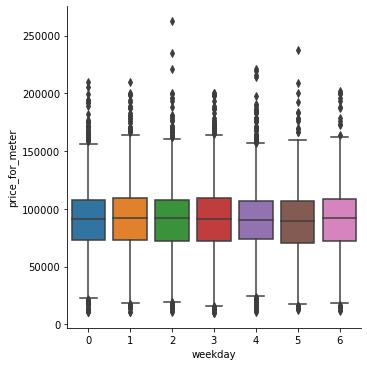

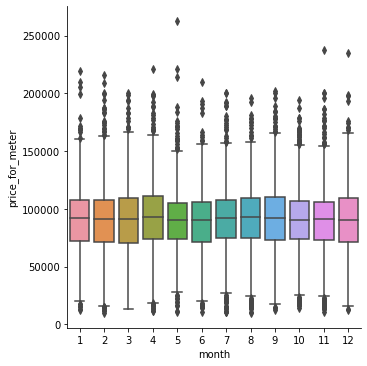

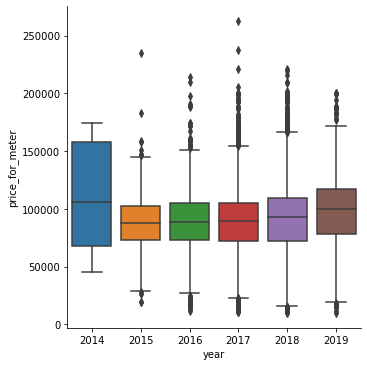

In [134]:
# Посмотрим влияние дня, месяца и года размещения объявления на рынке в целом
for column in ['weekday', 'month', 'year']:
    sns.catplot(x=column, y='price_for_meter', kind='box', data=normal_df)

В центре отмечается повышение стоимости в выходные дни, тогда как на рынке в целом цена одинаковая на протяжении всей недели.
Медианные значения цены за метр недвижимости отличаются. Так в центре ярко выражено увеличение в марте и снижение в июне, плюс необычно растянутые границы нормальных значений в мае.
Ежегодно цена за кв. м имеет динамику увеличения.

Сведём в одну таблицу средние значения центральной части и всего рынка и сравним значения интересующих нас параметров.

In [135]:
center_corr_df1 = center_df[['total_area', 
                             'rooms', 
                             'ceiling_height', 
                             'cityCenters_nearest', 
                             'floor_category', 
                             'weekday', 'month', 'year', 
                             'price_for_meter'
                            ]].mean().round(2)
center_corr_df1

total_area                 61.14
rooms                       2.17
ceiling_height              2.76
cityCenters_nearest      5764.72
weekday                     2.55
month                       6.40
year                     2017.34
price_for_meter        117922.52
dtype: float64

In [136]:
normal_df1 = normal_df[['total_area', 
                             'rooms', 
                             'ceiling_height', 
                             'cityCenters_nearest', 
                             'floor_category', 
                             'weekday', 'month', 'year', 
                             'price_for_meter'
                            ]].mean().round(2)
normal_df1

total_area                52.53
rooms                      1.92
ceiling_height             2.65
cityCenters_nearest    15533.81
weekday                    2.57
month                      6.27
year                    2017.43
price_for_meter        90493.14
dtype: float64

In [137]:
center_corr_df1.values

array([6.1140000e+01, 2.1700000e+00, 2.7600000e+00, 5.7647200e+03,
       2.5500000e+00, 6.4000000e+00, 2.0173400e+03, 1.1792252e+05])

In [138]:
normal_df1.values

array([5.253000e+01, 1.920000e+00, 2.650000e+00, 1.553381e+04,
       2.570000e+00, 6.270000e+00, 2.017430e+03, 9.049314e+04])

In [139]:
center_corr_df1.index

Index(['total_area', 'rooms', 'ceiling_height', 'cityCenters_nearest',
       'weekday', 'month', 'year', 'price_for_meter'],
      dtype='object')

In [140]:
d = {
    "Квартиры в центре":[6.1140000e+01, 2.1700000e+00, 2.7600000e+00, 5.7647200e+03, 
                         2.5500000e+00, 6.4000000e+00, 2.0173400e+03, 1.1792252e+05],
    "Все квартиры":[5.253000e+01, 1.920000e+00, 2.650000e+00, 1.553381e+04, 
                    2.570000e+00, 6.270000e+00, 2.017430e+03, 9.049314e+04]
}

df_ss = pd.DataFrame(d, index=['total_area', 'rooms', 'ceiling_height', 'cityCenters_nearest', 
                               'weekday', 'month', 'year', 'price_for_meter'])

df_ss

,Квартиры в центре,Все квартиры
total_area,61.14,52.53
rooms,2.17,1.92
ceiling_height,2.76,2.65
cityCenters_nearest,5764.72,15533.81
weekday,2.55,2.57
month,6.40,6.27
year,2017.34,2017.43
price_for_meter,117922.52,90493.14


In [141]:
df_ss['ratio'] = (df_ss["Квартиры в центре"] / df_ss["Все квартиры"] - 1) * 100
df_ss

,Квартиры в центре,Все квартиры,ratio
total_area,61.14,52.53,16.390634
rooms,2.17,1.92,13.020833
ceiling_height,2.76,2.65,4.150943
cityCenters_nearest,5764.72,15533.81,-62.889207
weekday,2.55,2.57,-0.778210
month,6.40,6.27,2.073365
year,2017.34,2017.43,-0.004461
price_for_meter,117922.52,90493.14,30.311005


Сравнивая данные всех предложений с предложниями в центре, можно сделать следующие выводы:

* Площадь квартиры продаваемых квартир в центре составляет в среднем почти 62 кв. м, что на 17,95% больше, чем средняя площадь квартир без учета локации.
* Лидируют по прежнему предложения с 2 комнатами, но в центре таких квартир на 14% больше.
* Высота потолков в квартирах центральной части на 10 см выше.
* Цена квадратного метра в центре на 31% дороже и составляет 118946 руб.

## Этап 5. Результаты

### Выводы

В ходе исследования рынка недвижимости Санкт Петербурга и соседних населенных пунктов мы обработали массив данных сервиса Яндекс.Недвижимость. Определили и изучили пропущенные значения, заполнили пропуски, где это уместно и предположили причины их появления.

1. В большинстве строк отсутствуют расстояния до аэропорта, центра,а также расстояния до парков, прудов и их количество в радиусе 3 км. Вероятно, люди или не знают таких параметров или им может быть лень их заполнять. В идеале такие параметры должны заполняться автоматически, при указании геолокации.
2. Почти у 39% объявлений не указана высота потолков. Данный параметр тоже мог бы генерироваться автоматически, если высота потолоков в типовом доме.
3. В 13% обявлений не указано сколько прошло дней от публикации до снятия. Вероятно, они не были сняты.
4. Площадь кухни и жилая площадь не указана у чуть менее 10% оъявлений.
5. В 88% объявлений не указан статус отношения к аппартаментам. Предположим, что это поле было проигнорировано при заполнении у не апартаментов.

Мы смогли привести данные к нужным типам. Посчитали и добавили в таблицу:
* цену квадратного метра;
* день недели, месяц и год публикации объявления;
* этаж квартиры; варианты — первый, последний, другой;
* соотношение жилой и общей площади, а также отношение площади кухни к общей.

Убрали редкие и выбивающиеся значения. Изучили влияние площади, числа комнат, высоты потолков, этажности. расстояния от центра и даже времени публикации на стоимость недвижимости. Выяснили, что наибольшее влияние имеют: число комнат, площадь квартиры, удаленность от центра и высота потолков.

Изучив время продажи квартиры, мы увидели, что обычно квартиры продаются за 90 дней, а четверть квартир была продана всего за 45 дней. Нормальным можно считать период 45 - 231 день. Также можем сказать, что квартира продавалась необычно долго, если объявлению больше 510 дней.

### Рекомендации

Сервису Яндекс.Недвижимость хотелось бы порекомендовать добавить автоматизации при заполнении части параметров. Это будет полезно как для удобства пользователей, так и для снижения вероятности ошибки и отсутствия данных.

**Описание данных**

* *airports_nearest* — расстояние до ближайшего аэропорта в метрах (м);
* *balcony* — число балконов;
* *ceiling_height* — высота потолков (м);
* *cityCenters_nearest* — расстояние до центра города (м);
* *days_exposition* — сколько дней было размещено объявление (от публикации до снятия);
* *first_day_exposition* — дата публикации;
* *floor* — этаж;
* *floors_total* — всего этажей в доме;
* *is_apartment* — апартаменты (булев тип);
* *kitchen_area* — площадь кухни в квадратных метрах (м²);
* *last_price* — цена на момент снятия с публикации;
* *living_area* — жилая площадь в квадратных метрах (м²);
* *locality_name* — название населённого пункта;
* *open_plan* — свободная планировка (булев тип);
* *parks_around3000* — число парков в радиусе 3 км;
* *parks_nearest* — расстояние до ближайшего парка (м);
* *ponds_around3000* — число водоёмов в радиусе 3 км;
* *ponds_nearest* — расстояние до ближайшего водоёма (м);
* *rooms* — число комнат;
* *studio* — квартира-студия (булев тип);
* *total_area* — площадь квартиры в квадратных метрах (м²);
* *total_images* — число фотографий квартиры в объявлении.